In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st
import warnings
from statsmodels.stats.proportion import proportions_ztest

import simpy
import random
import statistics

In [2]:
marketplace_df = pd.read_csv('marketplace.csv')

# Исследование Кирилла Гусева

## 0. Предобработка

In [3]:
marketplace_df = marketplace_df.drop('Unnamed: 0',axis = 1)

In [4]:
marketplace_df.head(10)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438
5,2024-10-01 01:23:00,2024-10-01 01:52:18,3046228,М,mobile,одежда и обувь,True,10,5,11364
6,2024-10-01 01:26:42,2024-10-01 01:56:58,3365488,М,desktop,все для дома,False,0,4,23301
7,2024-10-01 01:37:37,2024-10-01 02:11:07,6286723,Ж,desktop,красота и здоровье,False,0,6,2575
8,2024-10-01 01:38:22,2024-10-01 01:56:48,8145525,Ж,mobile,одежда и обувь,True,8,2,10430
9,2024-10-01 01:39:36,2024-10-01 02:14:10,8280464,Ж,desktop,одежда и обувь,True,13,4,26667


In [5]:
marketplace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_session       13620 non-null  object
 1   end_session         13620 non-null  object
 2   user_id             13620 non-null  int64 
 3   sex                 13620 non-null  object
 4   platform            13620 non-null  object
 5   category            13620 non-null  object
 6   consultation        13620 non-null  bool  
 7   cons_duration       13620 non-null  int64 
 8   number_of_products  13620 non-null  int64 
 9   basket_amount       13620 non-null  int64 
dtypes: bool(1), int64(4), object(5)
memory usage: 971.1+ KB


In [6]:
marketplace_df.head(10)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438
5,2024-10-01 01:23:00,2024-10-01 01:52:18,3046228,М,mobile,одежда и обувь,True,10,5,11364
6,2024-10-01 01:26:42,2024-10-01 01:56:58,3365488,М,desktop,все для дома,False,0,4,23301
7,2024-10-01 01:37:37,2024-10-01 02:11:07,6286723,Ж,desktop,красота и здоровье,False,0,6,2575
8,2024-10-01 01:38:22,2024-10-01 01:56:48,8145525,Ж,mobile,одежда и обувь,True,8,2,10430
9,2024-10-01 01:39:36,2024-10-01 02:14:10,8280464,Ж,desktop,одежда и обувь,True,13,4,26667


In [7]:
marketplace_df['start_session'] = pd.to_datetime(marketplace_df['start_session'])
marketplace_df['end_session'] = pd.to_datetime(marketplace_df['end_session'])
marketplace_df['sex'] = marketplace_df['sex'].astype('category')
marketplace_df['platform'] = marketplace_df['platform'].astype('category')
marketplace_df['category'] = marketplace_df['category'].astype('category')
marketplace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_session       13620 non-null  datetime64[ns]
 1   end_session         13620 non-null  datetime64[ns]
 2   user_id             13620 non-null  int64         
 3   sex                 13620 non-null  category      
 4   platform            13620 non-null  category      
 5   category            13620 non-null  category      
 6   consultation        13620 non-null  bool          
 7   cons_duration       13620 non-null  int64         
 8   number_of_products  13620 non-null  int64         
 9   basket_amount       13620 non-null  int64         
dtypes: bool(1), category(3), datetime64[ns](2), int64(4)
memory usage: 692.4 KB


## 1. Какова средняя длительность сессий?

In [8]:
marketplace_df['session_duration_seconds'] = (marketplace_df['end_session'] - marketplace_df['start_session']).dt.total_seconds()
mean_duration_seconds = marketplace_df['session_duration_seconds'].mean()
mean_duration_minutes = mean_duration_seconds / 60

print('Средняя длительность сессии в секундах =',round(mean_duration_seconds,3))
print('Средняя длительность сессии в минутах =',round(mean_duration_minutes,3))

Средняя длительность сессии в секундах = 1497.733
Средняя длительность сессии в минутах = 24.962


## 2.  Различается ли она в каждом месяце?

Извлекаем месяц и год

In [9]:
marketplace_df['month'] = marketplace_df['start_session'].dt.month
marketplace_df['year'] = marketplace_df['start_session'].dt.year

Группируем по году и месяцу, считаем среднюю длительность

In [10]:
monthly_avg_duration = marketplace_df.groupby(['year', 'month'])['session_duration_seconds'].mean().reset_index()

Переводим секунды в минуты для удобства чтения

In [11]:
monthly_avg_duration['avg_duration_minutes'] = monthly_avg_duration['session_duration_seconds'] / 60
monthly_avg_duration['avg_duration_hours'] = monthly_avg_duration['session_duration_seconds'] / 3600

In [12]:
print("Средняя длительность сессии по месяцам:")
print(monthly_avg_duration[['year', 'month', 'avg_duration_minutes', 'avg_duration_hours']].round(2))

Средняя длительность сессии по месяцам:
   year  month  avg_duration_minutes  avg_duration_hours
0  2024     10                 24.93                0.42
1  2024     11                 24.96                0.42
2  2024     12                 24.98                0.42


## 3. Различается ли она для мужчин и женщин?

In [13]:
gender_avg_duration = marketplace_df.groupby('sex',observed=False)['session_duration_seconds'].agg(['count','mean','std','median']).round(2)

In [14]:
# 3. Добавляем длительность в минутах и часы
gender_avg_duration['mean_minutes'] = gender_avg_duration['mean'] / 60
gender_avg_duration['mean_hours'] = gender_avg_duration['mean'] / 3600
print("Средняя длительность сессии по полу:")
print(gender_avg_duration[['count', 'mean', 'mean_minutes', 'mean_hours']])

Средняя длительность сессии по полу:
     count     mean  mean_minutes  mean_hours
sex                                          
Ж     6887  1494.80     24.913333    0.415222
М     6733  1500.73     25.012167    0.416869


## 4. Различается ли она для покупателей, использующих веб-сайт или мобильное приложение?

In [15]:
a = marketplace_df[['platform','start_session','end_session']]

desktop = a.loc[a['platform'] == 'desktop'].copy()
mobile = a.loc[a['platform'] == 'mobile'].copy()

desktop['session_duration_seconds'] = (desktop['end_session'] - desktop['start_session']).dt.total_seconds()
mobile['session_duration_seconds'] = (mobile['end_session'] - mobile['start_session']).dt.total_seconds()

cnt_desktop = len(desktop)
cnt_mobile = len(mobile)

b = desktop['session_duration_seconds'].mean() ; b1 = float(round(b,2))
c = mobile['session_duration_seconds'].mean() ; c1 = float(round(c,2))

print('Общее количество клиентов, использующих веб-сайт =',cnt_desktop)
print('Общее количество клиентов, использующих мобильное приложение =',cnt_mobile)
print('Средняя длительность сессии клиентов, использующих веб-сайт = ',b1,'сек ;',round(b1/60,2),'мин')
print('Средняя длительность сессии клиентов, использующих мобильное приложение = ',c1,'сек ;',round(c1/60,2),'мин')

Общее количество клиентов, использующих веб-сайт = 5629
Общее количество клиентов, использующих мобильное приложение = 7991
Средняя длительность сессии клиентов, использующих веб-сайт =  1502.71 сек ; 25.05 мин
Средняя длительность сессии клиентов, использующих мобильное приложение =  1494.22 сек ; 24.9 мин


## 5. Какова интенсивность потока покупателей?

In [16]:
min_date = marketplace_df['start_session'].min() ; max_date = marketplace_df['start_session'].max()
# Считаем разницу
time_span = max_date - min_date

print(f"Начало наблюдения: {min_date}")
print(f"Конец наблюдения: {max_date}")
print(f"Время наблюдения: {time_span}")

Начало наблюдения: 2024-10-01 00:15:51
Конец наблюдения: 2024-12-31 23:25:35
Время наблюдения: 91 days 23:09:44


In [17]:
total_seconds = time_span.total_seconds()
cnt_observation = len(marketplace_df)

total_minutes = total_seconds / 60
total_hours = total_seconds / 3600
total_days = total_seconds / 86400
total_months = total_days / 30.33

intensity_per_second = 1 / (total_seconds / cnt_observation)
intensity_per_minute = 1 / (total_minutes / cnt_observation)
intensity_per_hour = 1 / (total_hours / cnt_observation)
intensity_per_day = 1 / (total_days / cnt_observation)
intensity_per_month = 1 / (total_months / cnt_observation)

print(' На общее время наблюдения по всему датасету,\n интенсивность потока покупателей составила:')
print('λ = ',round(intensity_per_second,4),'- заявки в секунду')
print('λ = ',round(intensity_per_minute,4),'- заявки в минуту')
print('λ = ',round(intensity_per_hour,4),'- заявки в час')
print('λ = ',round(intensity_per_day,4),'- заявок в день')
print('λ = ',round(intensity_per_month,4),'- заявок в месяц')

 На общее время наблюдения по всему датасету,
 интенсивность потока покупателей составила:
λ =  0.0017 - заявки в секунду
λ =  0.1028 - заявки в минуту
λ =  6.1708 - заявки в час
λ =  148.0997 - заявок в день
λ =  4491.863 - заявок в месяц


## 6. Менялась ли она в течение трех месяцев?

In [18]:
m = marketplace_df[['month','start_session','end_session']]

october = m.loc[m['month'] == 10].copy()
november = m.loc[m['month'] == 11].copy()
december = m.loc[m['month'] == 12].copy()

Октябрь

In [19]:
min_date_october = october['start_session'].min()
max_date_october = october['start_session'].max()

time_span_october = max_date_october - min_date_october
print('Октябрь:')
print(f"Начало наблюдения: {min_date_october}")
print(f"Конец наблюдения: {max_date_october}")
print(f"Время наблюдения: {time_span_october}")

Октябрь:
Начало наблюдения: 2024-10-01 00:15:51
Конец наблюдения: 2024-10-30 23:55:07
Время наблюдения: 29 days 23:39:16


In [20]:
total_seconds_october = time_span_october.total_seconds() ; cnt_observation_october = len(october)

total_minutes_october = total_seconds_october / 60 ; total_hours_october = total_seconds_october / 3600 ; total_days_october = total_seconds_october / 86400

intensity_per_second_october = 1 / (total_seconds_october / cnt_observation_october)
intensity_per_minute_october = 1 / (total_minutes_october / cnt_observation_october)
intensity_per_hour_october = 1 / (total_hours_october / cnt_observation_october)
intensity_per_day_october = 1 / (total_days_october / cnt_observation_october)

print('За октябрь интенсивность потока покупателей составила:')
print('λ = ',round(intensity_per_second_october,4),'- заявки в секунду ')
print('λ = ',round(intensity_per_minute_october,4),'- заявки в минуту ')
print('λ = ',round(intensity_per_hour_october,4),'- заявки в час ')
print('λ = ',round(intensity_per_day_october,4),'- заявок в день ')
print('Всего за октябрь =',cnt_observation_october,'заявки')

За октябрь интенсивность потока покупателей составила:
λ =  0.0012 - заявки в секунду 
λ =  0.0708 - заявки в минуту 
λ =  4.2507 - заявки в час 
λ =  102.0156 - заявок в день 
Всего за октябрь = 3059 заявки


Ноябрь

In [21]:
min_date_november = november['start_session'].min()
max_date_november = november['start_session'].max()

time_span_november = max_date_november - min_date_november
print('Ноябрь:')
print(f"Начало наблюдения: {min_date_november}")
print(f"Конец наблюдения: {max_date_november}")
print(f"Время наблюдения: {time_span_november}")

Ноябрь:
Начало наблюдения: 2024-11-01 00:18:13
Конец наблюдения: 2024-11-29 23:55:41
Время наблюдения: 28 days 23:37:28


In [22]:
total_seconds_november = time_span_november.total_seconds() ; cnt_observation_november = len(november)

total_minutes_november = total_seconds_november / 60 ; total_hours_november = total_seconds_november / 3600 ; total_days_november = total_seconds_november / 86400

intensity_per_second_november = 1 / (total_seconds_november / cnt_observation_november)
intensity_per_minute_november = 1 / (total_minutes_november / cnt_observation_november)
intensity_per_hour_november = 1 / (total_hours_november / cnt_observation_november)
intensity_per_day_november = 1 / (total_days_november / cnt_observation_november)

print('За ноябрь интенсивность потока покупателей составила:')
print('λ = ',round(intensity_per_second_november,4),'- заявки в секунду ')
print('λ = ',round(intensity_per_minute_november,4),'- заявки в минуту ')
print('λ = ',round(intensity_per_hour_november,4),'- заявки в час ')
print('λ = ',round(intensity_per_day_november,4),'- заявок в день ')
print('Всего за ноябрь =',cnt_observation_november,'заявки')

За ноябрь интенсивность потока покупателей составила:
λ =  0.0018 - заявки в секунду 
λ =  0.1051 - заявки в минуту 
λ =  6.3051 - заявки в час 
λ =  151.323 - заявок в день 
Всего за ноябрь = 4386 заявки


Декабрь

In [23]:
min_date_december = december['start_session'].min()
max_date_december = december['start_session'].max()

time_span_december = max_date_december - min_date_december
print('Декабрь:')
print(f"Начало наблюдения: {min_date_december}")
print(f"Конец наблюдения: {max_date_december}")
print(f"Время наблюдения: {time_span_december}")

Декабрь:
Начало наблюдения: 2024-12-01 00:09:55
Конец наблюдения: 2024-12-31 23:25:35
Время наблюдения: 30 days 23:15:40


In [24]:
total_seconds_december = time_span_december.total_seconds() ; cnt_observation_december = len(december)

total_minutes_december = total_seconds_december / 60 ; total_hours_december = total_seconds_december / 3600 ; total_days_december = total_seconds_november / 86400

intensity_per_second_december = 1 / (total_seconds_december / cnt_observation_december)
intensity_per_minute_december = 1 / (total_minutes_december / cnt_observation_december)
intensity_per_hour_december = 1 / (total_hours_december/ cnt_observation_december)
intensity_per_day_december = 1 / (total_days_december / cnt_observation_december)

print('За декабрь интенсивность потока покупателей составила:')
print('λ = ',round(intensity_per_second_december,4),'- заявки в секунду ')
print('λ = ',round(intensity_per_minute_december,4),'- заявки в минуту ')
print('λ = ',round(intensity_per_hour_december,4),'- заявки в час ')
print('λ = ',round(intensity_per_day_december,4),'- заявок в день ')
print('Всего за ноябрь =',cnt_observation_december,'заявки')

За декабрь интенсивность потока покупателей составила:
λ =  0.0023 - заявки в секунду 
λ =  0.1385 - заявки в минуту 
λ =  8.308 - заявки в час 
λ =  213.046 - заявок в день 
Всего за ноябрь = 6175 заявки


## Визуализация ( 5 и 6 вопрос )

In [25]:
data = {
    'Месяц':          ['Октябрь', 'Ноябрь', 'Декабрь'],
    'Заявки_час':     [intensity_per_hour_october,intensity_per_hour_november,intensity_per_hour_december],
    'Заявки_день':    [intensity_per_day_october,intensity_per_day_november,intensity_per_day_december],
    'Заявки_месяц':   [cnt_observation_october,cnt_observation_november,cnt_observation_december]
}

df_intensity = pd.DataFrame(data) ; df_intensity.set_index('Месяц', inplace=True)
pd.set_option('display.float_format', '{:.0f}'.format) # {:.0f} - регулятор точности отображения
df_intensity

,Заявки_час,Заявки_день,Заявки_месяц
Месяц,,,
Октябрь,4,102,3059
Ноябрь,6,151,4386
Декабрь,8,213,6175


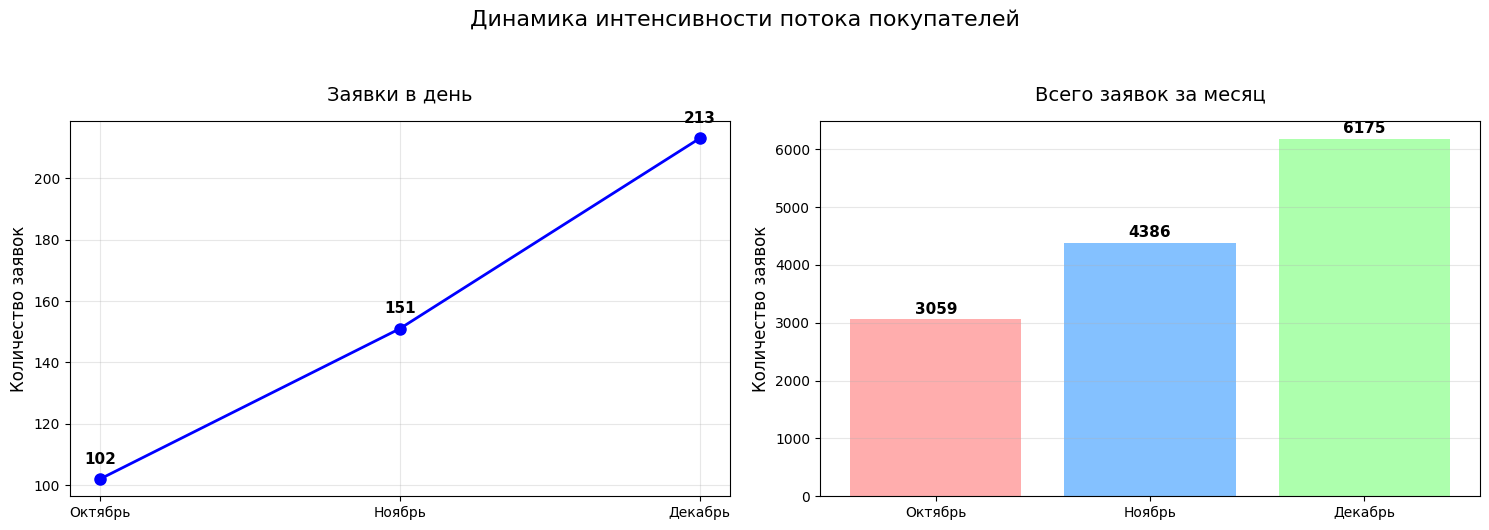

In [26]:
df_intensity = pd.DataFrame({
    'Месяц': ['Октябрь', 'Ноябрь', 'Декабрь'],
    'Заявки_час': [4, 6, 8],
    'Заявки_день': [102, 151, 213],
    'Заявки_месяц': [3059, 4386, 6175]
})

df_intensity.set_index('Месяц', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(df_intensity.index, df_intensity['Заявки_день'], marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_title('Заявки в день', fontsize=14, pad=15)
axes[0].set_ylabel('Количество заявок', fontsize=12)
axes[0].grid(True, alpha=0.3)
for i, val in enumerate(df_intensity['Заявки_день']):
    axes[0].text(i, val + 5, f'{val}', ha='center', fontsize=11, fontweight='bold')

axes[1].bar(df_intensity.index, df_intensity['Заявки_месяц'], color=['#FF9999', '#66B2FF', '#99FF99'], alpha=0.8)
axes[1].set_title('Всего заявок за месяц', fontsize=14, pad=15)
axes[1].set_ylabel('Количество заявок', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

for i, val in enumerate(df_intensity['Заявки_месяц']):
    axes[1].text(i, val + 100, f'{val}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Динамика интенсивности потока покупателей', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


## 7. Какова вероятность того, что клиент вернется за покупками на ВезуМаркет?

### 7.1 Проведем исследование клиенткой базы и фактора лояльности клиента для развития маркетплейса

In [27]:
customer_ret = marketplace_df[['user_id','consultation','cons_duration','basket_amount','month','year']]
customer_ret

,user_id,consultation,cons_duration,basket_amount,month,year
0,5209870,True,13,348,10,2024
1,2540815,False,0,162,10,2024
2,5305770,False,0,8188,10,2024
3,5858087,False,0,11640,10,2024
4,5711053,False,0,2438,10,2024
...,...,...,...,...,...,...
13615,7766167,False,0,1632,12,2024
13616,4061473,False,0,41266,12,2024
13617,3864302,False,0,4760,12,2024
13618,2361461,True,9,324,12,2024


In [28]:
value_counts = customer_ret['user_id'].value_counts()
duplicate_ids = value_counts[value_counts > 1].index
mask_duplicates = customer_ret['user_id'].isin(duplicate_ids)
#-------------------------------------------------------------------------------
unique_users_df = customer_ret[ ~ mask_duplicates ]  # пользователи с 1 записью
duplicate_users_df = customer_ret[ mask_duplicates ]  # пользователи с > 2 записи

In [29]:
value_counts = duplicate_users_df['user_id'].value_counts()
duplicate_ids = value_counts[value_counts > 2].index
mask_duplicates = duplicate_users_df['user_id'].isin(duplicate_ids)
#-------------------------------------------------------------------------------
unique_users_df = duplicate_users_df[ ~ mask_duplicates ]  # пользователи с 1 записью
duplicate_users_df_3 = duplicate_users_df[ mask_duplicates ]  # пользователи с > 3 записи

In [30]:
value_counts = duplicate_users_df['user_id'].value_counts()
duplicate_ids = value_counts[value_counts > 3].index
mask_duplicates = duplicate_users_df['user_id'].isin(duplicate_ids)
#-------------------------------------------------------------------------------
unique_users_df = duplicate_users_df[ ~ mask_duplicates ]  # пользователи с 1 записью
duplicate_users_df_4 = duplicate_users_df[ mask_duplicates ]  # пользователи с > 4 записи

In [31]:
value_counts = duplicate_users_df['user_id'].value_counts()
duplicate_ids = value_counts[value_counts > 4].index
mask_duplicates = duplicate_users_df['user_id'].isin(duplicate_ids)
#-------------------------------------------------------------------------------
unique_users_df = duplicate_users_df[ ~ mask_duplicates ]  # пользователи с 1 записью
duplicate_users_df_5 = duplicate_users_df[ mask_duplicates ]  # пользователи с > 5 записи

In [32]:
value_counts = duplicate_users_df['user_id'].value_counts()
duplicate_ids = value_counts[value_counts > 5].index
mask_duplicates = duplicate_users_df['user_id'].isin(duplicate_ids)
#-------------------------------------------------------------------------------
unique_users_df = duplicate_users_df[ ~ mask_duplicates ]  # пользователи с 1 записью
duplicate_users_df_6 = duplicate_users_df[ mask_duplicates ]  # пользователи с > 6 записи

In [33]:
value_counts = duplicate_users_df['user_id'].value_counts()
duplicate_ids = value_counts[value_counts > 6].index
mask_duplicates = duplicate_users_df['user_id'].isin(duplicate_ids)
#-------------------------------------------------------------------------------
unique_users_df = duplicate_users_df[ ~ mask_duplicates ]  # пользователи с 1 записью
duplicate_users_df_7 = duplicate_users_df[ mask_duplicates ]  # пользователи с > 7 записи

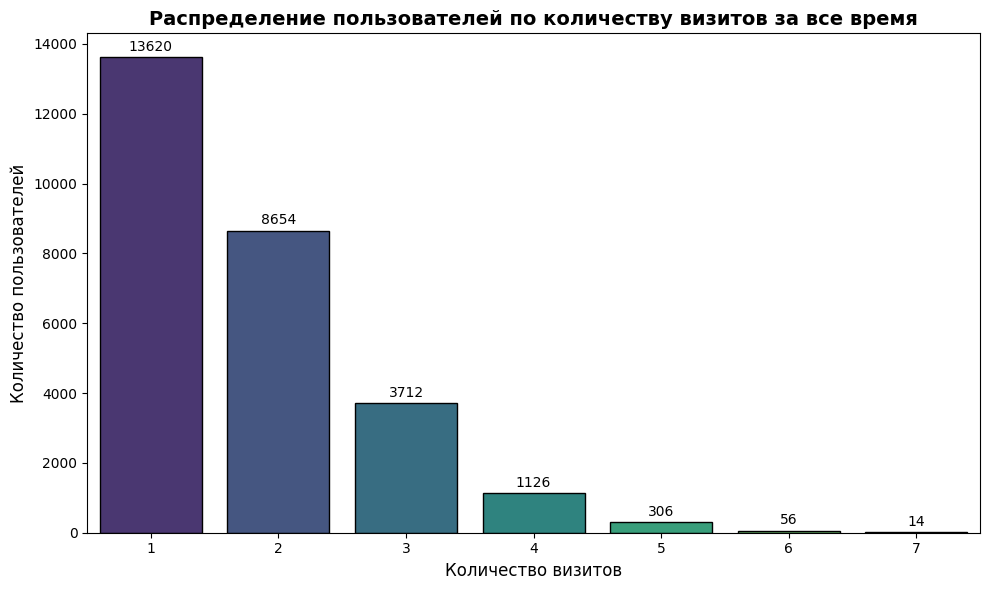

In [34]:
df_visits = pd.DataFrame({
    'Количество_визитов': ['1', '2', '3', '4', '5', '6', '7'],
    'Пользователи': [13620, 8654, 3712, 1126, 306, 56, 14]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_visits, x='Количество_визитов', y='Пользователи', hue='Количество_визитов', palette='viridis', edgecolor='black', legend=False)
plt.title('Распределение пользователей по количеству визитов за все время', fontsize=14, fontweight='bold')
plt.xlabel('Количество визитов', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)

for i, value in enumerate(df_visits['Пользователи']):
    plt.text(i, value + 100, f'{value}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [35]:
z = customer_ret['basket_amount'].sum()
a = duplicate_users_df['basket_amount'].sum()
b = duplicate_users_df_3['basket_amount'].sum()
c = duplicate_users_df_4['basket_amount'].sum()
d = duplicate_users_df_5['basket_amount'].sum()
e = duplicate_users_df_6['basket_amount'].sum()
f = duplicate_users_df_7['basket_amount'].sum()

In [36]:
vizit_client = np.array([13620, 8654, 3712, 1126, 306, 56, 14])
summ_basket = np.array([z, a, b, c, d, e, f])
sr_basket = summ_basket / vizit_client

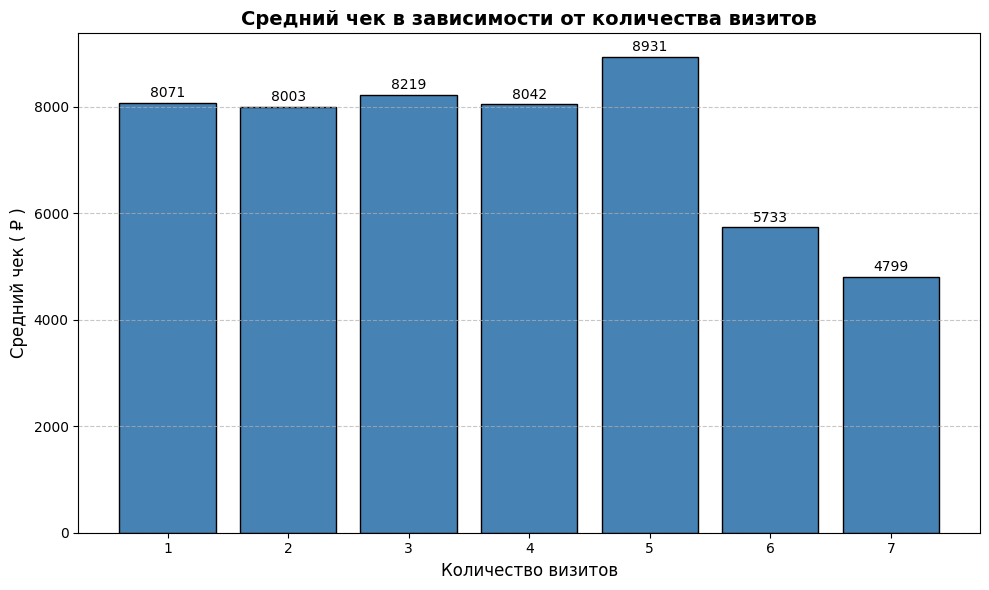

In [37]:
vizit_client = np.array([1, 2, 3, 4, 5, 6, 7])
sn_basket = np.array([8070.58, 8002.77, 8219.30, 8041.64, 8930.52, 5732.68, 4799.29])

plt.figure(figsize=(10, 6))
plt.bar(vizit_client, sn_basket, color='steelblue', edgecolor='black')
plt.xlabel('Количество визитов', fontsize=12)
plt.ylabel('Средний чек ( ₽ )', fontsize=12)
plt.title('Средний чек в зависимости от количества визитов', fontsize=14, fontweight='bold')

for x, y in zip(vizit_client, sn_basket):
    plt.text(x, y + 50, f'{y:.0f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

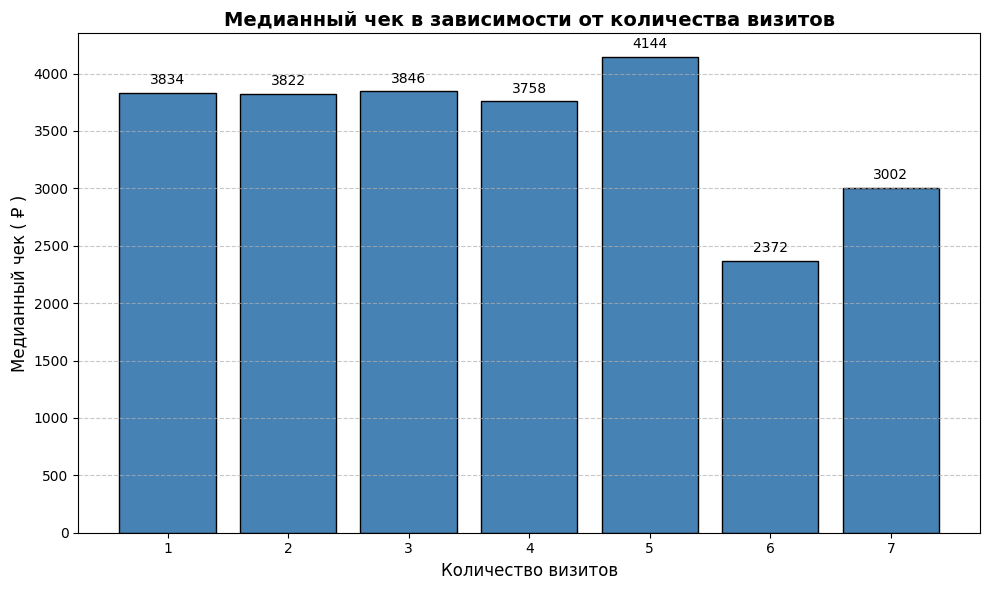

In [38]:
vizit_client = np.array([1, 2, 3, 4, 5, 6, 7])
median_basket = np.array([3834.5, 3821.5, 3845.5, 3757.5, 4143.5, 2371.5, 3001.5])

plt.figure(figsize=(10, 6))
plt.bar(vizit_client, median_basket ,color='steelblue', edgecolor='black')
plt.xlabel('Количество визитов', fontsize=12)
plt.ylabel('Медианный чек ( ₽ )', fontsize=12)
plt.title('Медианный чек в зависимости от количества визитов', fontsize=14, fontweight='bold')

for x, y in zip(vizit_client, median_basket):
    plt.text(x, y + 50, f'{y:.0f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [39]:
z = len(customer_ret['basket_amount'])
a = len(duplicate_users_df['basket_amount'])
b = len(duplicate_users_df_3['basket_amount'])
c = len(duplicate_users_df_4['basket_amount'])
d = len(duplicate_users_df_5['basket_amount'])
e = len(duplicate_users_df_6['basket_amount'])
f = len(duplicate_users_df_7['basket_amount'])

In [40]:
zz = len(customer_ret[customer_ret['consultation'] == True])                ; zzz = len(customer_ret[customer_ret['consultation'] == False])
aa = len(duplicate_users_df[duplicate_users_df['consultation'] == True])    ; aaa = len(duplicate_users_df[duplicate_users_df['consultation'] == False])
bb = len(duplicate_users_df_3[duplicate_users_df_3['consultation'] == True]); bbb = len(duplicate_users_df_3[duplicate_users_df_3['consultation'] == False])
cc = len(duplicate_users_df_4[duplicate_users_df_4['consultation'] == True]); ccc = len(duplicate_users_df_4[duplicate_users_df_4['consultation'] == False])
dd = len(duplicate_users_df_5[duplicate_users_df_5['consultation'] == True]); ddd = len(duplicate_users_df_5[duplicate_users_df_5['consultation'] == False])
ee = len(duplicate_users_df_6[duplicate_users_df_6['consultation'] == True]); eee = len(duplicate_users_df_6[duplicate_users_df_6['consultation'] == False])
ff = len(duplicate_users_df_7[duplicate_users_df_7['consultation'] == True]); fff = len(duplicate_users_df_7[duplicate_users_df_7['consultation'] == False])

In [41]:
true_1 = zz/z*100 ; false_1 = zzz/z*100
true_2 = aa/a*100 ; false_2 = aaa/a*100
true_3 = bb/b*100 ; false_3 = bbb/b*100
true_4 = cc/c*100 ; false_4 = ccc/c*100
true_5 = dd/d*100 ; false_5 = ddd/d*100
true_6 = ee/e*100 ; false_6 = eee/e*100
true_7 = ff/f*100 ; false_7 = fff/f*100

### 7.2 Исследуем фактор консультации в разрезе роста лояльности клиента

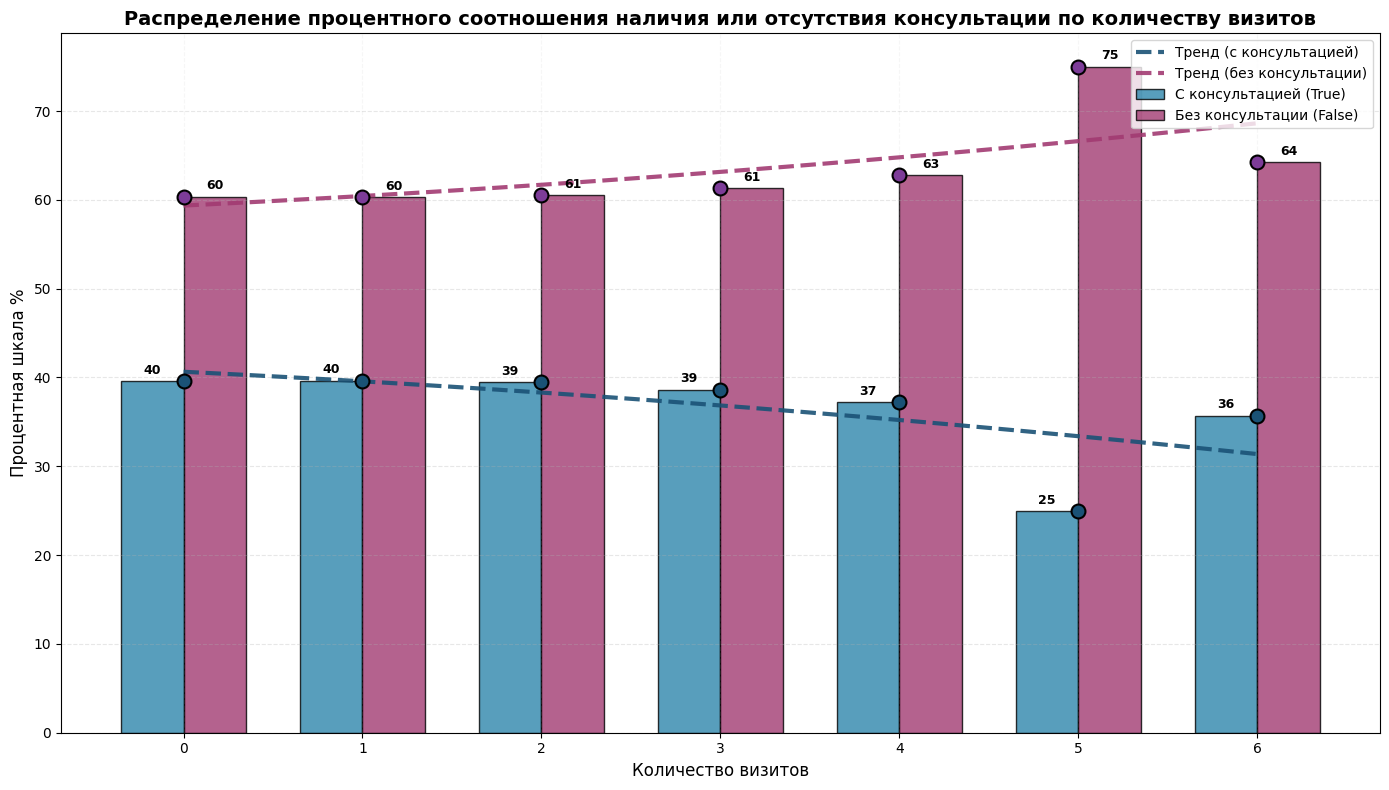

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

visits = [0, 1, 2, 3, 4, 5, 6]
true_users = [true_1, true_2, true_3, true_4, true_5, true_6, true_7]
false_users = [false_1, false_2, false_3, false_4, false_5, false_6, false_7]

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(visits))
width = 0.35

bars1 = ax.bar(x - width/2, true_users, width, label='С консультацией (True)', color='#2E86AB', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, false_users, width, label='Без консультации (False)', color='#A23B72', edgecolor='black', alpha=0.8)

X = np.array(visits).reshape(-1, 1)  # Количество визитов
y_true = np.array(true_users)         # Значения True
y_false = np.array(false_users)       # Значения False

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model_true = LinearRegression()
model_true.fit(X_poly, y_true)
y_true_pred = model_true.predict(X_poly)

model_false = LinearRegression()
model_false.fit(X_poly, y_false)
y_false_pred = model_false.predict(X_poly)

X_smooth = np.linspace(min(visits), max(visits), 100).reshape(-1, 1)
X_smooth_poly = poly.transform(X_smooth)

y_true_smooth = model_true.predict(X_smooth_poly)
y_false_smooth = model_false.predict(X_smooth_poly)

ax.plot(X_smooth, y_true_smooth, color='#1A5276', linewidth=3, linestyle='--',label='Тренд (с консультацией)', alpha=0.9)
ax.plot(X_smooth, y_false_smooth, color='#A23B72', linewidth=3, linestyle='--',label='Тренд (без консультации)', alpha=0.9)

ax.scatter(visits, true_users, color='#1A5276', s=100, zorder=5, edgecolor='black', linewidth=1.5)
ax.scatter(visits, false_users, color='#7D3C98', s=100, zorder=5, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Количество визитов', fontsize=12)
ax.set_ylabel('Процентная шкала %', fontsize=12)
ax.set_title('Распределение процентного соотношения наличия или отсутствия консультации по количеству визитов',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(visits)
ax.legend(loc='upper right')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

add_labels(bars1)
add_labels(bars2)

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.grid(axis='x', linestyle='--', alpha=0.1)

plt.tight_layout()
plt.show()

### 7.3 Как меняется время консультации в зависимости от визита клиента

In [43]:
z = customer_ret['cons_duration'].sum()
a = duplicate_users_df['cons_duration'].sum()
b = duplicate_users_df_3['cons_duration'].sum()
c = duplicate_users_df_4['cons_duration'].sum()
d = duplicate_users_df_5['cons_duration'].sum()
e = duplicate_users_df_6['cons_duration'].sum()
f = duplicate_users_df_7['cons_duration'].sum()

In [44]:
mean_time_con = z / len(customer_ret)
mean_time_con_2 = a / len(duplicate_users_df)
mean_time_con_3 = b / len(duplicate_users_df_3)
mean_time_con_4 = c / len(duplicate_users_df_4)
mean_time_con_5 = d / len(duplicate_users_df_5)
mean_time_con_6 = e / len(duplicate_users_df_6)
mean_time_con_7 = f / len(duplicate_users_df_7)

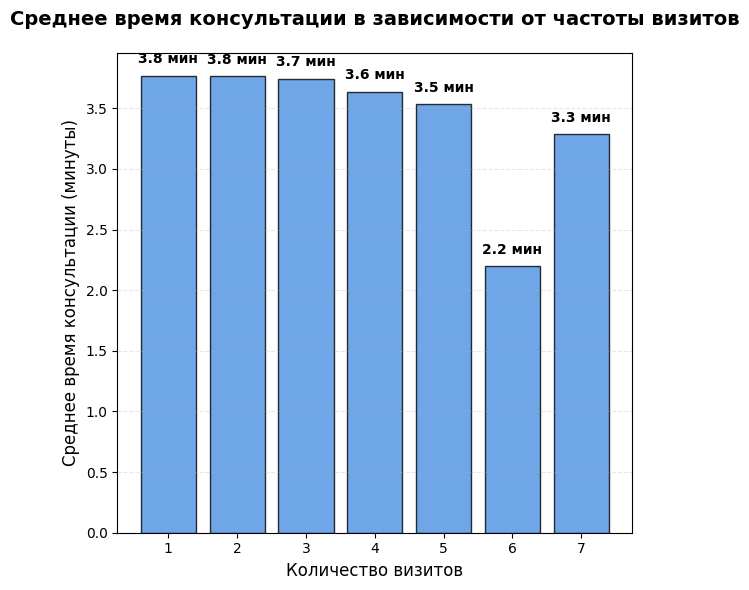

In [45]:
visits = [1, 2, 3, 4, 5, 6, 7]
users_count = [13620, 8654, 3712, 1126, 306, 56, 14]

mean_consultation_times = [
    mean_time_con,
    mean_time_con_2,
    mean_time_con_3,
    mean_time_con_4,
    mean_time_con_5,
    mean_time_con_6,
    mean_time_con_7
]

fig, ax1 = plt.subplots(figsize=(6, 6))

ax1.bar(visits, mean_consultation_times, color='#4A90E2', edgecolor='black', alpha=0.8)

ax1.set_title('Среднее время консультации в зависимости от частоты визитов',fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Среднее время консультации (минуты)', fontsize=12)
ax1.set_xlabel('Количество визитов', fontsize=12)
ax1.set_xticks(visits)
ax1.set_xticklabels(visits)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

for i, (visit, time) in enumerate(zip(visits, mean_consultation_times)):
    ax1.text(visit, time + max(mean_consultation_times)*0.02,
             f'{time:.1f} мин', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Как влияет консультация на продажи маркетплейса ?

### 8.1 Проведем общую оценку влияет ли консультация на продажи маркетплейса

In [46]:
consultation_on = customer_ret[customer_ret['consultation'] == True]
sum_con_true = consultation_on['basket_amount'].sum()
len_con_true = len(consultation_on)

In [47]:
consultation_off = customer_ret[customer_ret['consultation'] == False]
sum_con_false = consultation_off['basket_amount'].sum()
len_con_false = len(consultation_off)

In [48]:
sr_basket_con_true = sum_con_true / len_con_true
sr_basket_con_false = sum_con_false / len_con_false

In [49]:
data = {

    'Показатель': [
        'Сумма продаж',
        'Количество клиентов',
        'Средний чек'
    ],
    'С консультацией': [
        sum_con_true,
        len_con_true,
        sr_basket_con_true
    ],
    'Без консультации': [
        sum_con_false,
        len_con_false,
        sr_basket_con_false
    ]
}

df_comparison = pd.DataFrame(data)
df_comparison

,Показатель,С консультацией,Без консультации
0,Сумма продаж,44177593,65743695
1,Количество клиентов,5399,8221
2,Средний чек,8183,7997


In [50]:
median_basket_con_true = consultation_on['basket_amount'].median()
median_basket_con_false = consultation_off['basket_amount'].median()

In [51]:
data2 = {

    'Показатель': [
        'Сумма продаж',
        'Количество клиентов',
        'Медианный чек'
    ],
    'С консультацией': [
        sum_con_true,
        len_con_true,
        median_basket_con_true
    ],
    'Без консультации': [
        sum_con_false,
        len_con_false,
        median_basket_con_false
    ]
}

df_comparison = pd.DataFrame(data2)
df_comparison

,Показатель,С консультацией,Без консультации
0,Сумма продаж,44177593,65743695
1,Количество клиентов,5399,8221
2,Медианный чек,3835,3834


### 8.2 Проведем исследование CRR накопительно от месяца к месяцу

In [52]:
okt = customer_ret[customer_ret['month'] == 10]
nov = customer_ret[customer_ret['month'] == 11]
dec = customer_ret[customer_ret['month'] == 12]

In [53]:
okt_set = set(okt['user_id'])
nov_set = set(nov['user_id'])
dec_set = set(dec['user_id'])

In [54]:
okt_all  = len(okt)
okt_unic = len(okt['user_id'].unique())
okt_save = (len(okt)) - okt_unic
#---------------------------------------------------
nov_all = len(nov_set)
nov_unic = len(nov_set - okt_set)
nov_save = len(nov_set) - len(nov_set - okt_set)
#---------------------------------------------------
dec_all = len(dec_set)
dec_unic = len(dec_set - nov_set)
dec_save = len(dec_set) - (len(dec_set - nov_set))
#---------------------------------------------------
CRR_okt = (okt_save / okt_all * 100)
CRR_nov = (nov_save / okt_all * 100)
CRR_dec = (dec_save / nov_all * 100)

In [55]:
data = {
    'Месяц':                                        ['Октябрь','Ноябрь','Декабрь'],
    'Всего пользователей' :                         [len(okt),len(nov),len(dec)],
    'Всего уник.пользователей в месяце':            [okt_all, nov_all, dec_all],
    'Уник.новых по отношению к предыдущему месяцу': [f'{okt_unic} виз.кл = 1', nov_unic,dec_unic],
    'Сохраненных с предыдущего месяца':             [(f'{okt_save} виз.кл > 1'), nov_save, dec_save],
    'CRR %' :                                       [CRR_okt,CRR_nov,CRR_dec]
}
df = pd.DataFrame(data)
df

,Месяц,Всего пользователей,Всего уник.пользователей в месяце,Уник.новых по отношению к предыдущему месяцу,Сохраненных с предыдущего месяца,CRR %
0,Октябрь,3059,3059,2733 виз.кл = 1,326 виз.кл > 1,11
1,Ноябрь,4386,3762,2988,774,25
2,Декабрь,6175,4927,3545,1382,37


# Исследование Алексея Покрышкина

In [56]:
marketplace_df = pd.read_csv('marketplace.csv')
marketplace_df.sample(5)

,Unnamed: 0,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount
1369,1369,2024-10-14 12:23:44,2024-10-14 13:02:49,2634874,Ж,mobile,детские товары,True,14,5,12919
13229,13229,2024-12-30 00:43:34,2024-12-30 01:06:55,1462778,Ж,desktop,канцелярия,False,0,4,370
8051,8051,2024-12-04 00:40:33,2024-12-04 01:13:37,8444985,Ж,mobile,одежда и обувь,False,0,3,13198
12752,12752,2024-12-27 15:46:23,2024-12-27 15:57:07,4247409,Ж,desktop,красота и здоровье,True,4,2,3917
9528,9528,2024-12-11 14:17:49,2024-12-11 14:44:48,6006723,М,mobile,детские товары,False,0,3,8912


In [57]:
marketplace_df = marketplace_df.drop('Unnamed: 0',axis = 1)

In [58]:
marketplace_df.shape

(13620, 10)

In [59]:
marketplace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_session       13620 non-null  object
 1   end_session         13620 non-null  object
 2   user_id             13620 non-null  int64 
 3   sex                 13620 non-null  object
 4   platform            13620 non-null  object
 5   category            13620 non-null  object
 6   consultation        13620 non-null  bool  
 7   cons_duration       13620 non-null  int64 
 8   number_of_products  13620 non-null  int64 
 9   basket_amount       13620 non-null  int64 
dtypes: bool(1), int64(4), object(5)
memory usage: 971.1+ KB


#### В датафрейме нет пустых значений

In [60]:
marketplace_df.describe()

,user_id,cons_duration,number_of_products,basket_amount
count,13620,13620,13620,13620
mean,5014737,4,3,8071
std,2321852,5,2,10664
min,1000078,0,1,72
25%,3030951,0,2,1204
50%,4995020,0,3,3834
75%,7056691,8,5,10172
max,8999642,19,6,53385


In [61]:
# переводим небходимые столбцы в дату
marketplace_df['start_session'] = pd.to_datetime(marketplace_df['start_session'])
marketplace_df['end_session'] = pd.to_datetime(marketplace_df['end_session'])

In [62]:
# поиск возможных пустых значенйи в столбце
def check_masked_missing(df, column):

        # 1. Стандартные NaN/None
        nan_count = df[column].isna().sum()
        print(f"NaN/None: {nan_count}")

        # 2. Пустые строки ''
        empty_str = (df[column] == '').sum()
        print(f"Пустые строки (''): {empty_str}")

        # 3. Пробелы ' ', '\\t', '\\n'
        whitespace = df[column].astype(str).str.strip().eq('').sum()
        print(f"Только пробелы: {whitespace}")

        # 4. Специальные символы: ?, -, N/A, NULL, пусто
        suspicious = df[column].astype(str).str.lower()
        masks = ['?', '-', 'n/a', 'na', 'null', 'none', 'nan', '','!']
        for mask in masks:
            count = (suspicious == mask).sum()
            if count > 0:
                print(f"'{mask}': {count}")

        # 5. Строки из пробелов разной длины
        space_only = suspicious.str.match(r'^\s*$').sum()
        print(f"Только пробелы (regex): {space_only}")


In [63]:
check_masked_missing(marketplace_df, 'end_session')

NaN/None: 0
Пустые строки (''): 0
Только пробелы: 0
Только пробелы (regex): 0


## Верно ли, что женщины тратят больше денег на покупки на ВезуМаркет?

In [64]:
marketplace_df['month'] = marketplace_df['end_session'].dt.strftime('%Y-%m')

In [65]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [66]:
# Разбивка расходов по месяцам
cost_df = marketplace_df.groupby(['month','sex'],as_index=False) \
    .agg({'basket_amount':'sum'}).rename(columns={'basket_amount':'total_spending'})
cost_df

,month,sex,total_spending
0,2024-10,Ж,12280043
1,2024-10,М,12809949
2,2024-11,Ж,17720267
3,2024-11,М,16891579
4,2024-12,Ж,25781533
5,2024-12,М,24437917


In [67]:
women_sum = cost_df[cost_df['sex'] == 'Ж']['total_spending'].sum()
print(f'Женщины потратили на ВезуМаркет: {women_sum} руб.')

Женщины потратили на ВезуМаркет: 55781843 руб.


In [68]:
men_sum = cost_df[cost_df['sex'] == 'М']['total_spending'].sum()
print(f'Мужчины в сумме потратили на ВезуМаркет: {men_sum} руб.')

Мужчины в сумме потратили на ВезуМаркет: 54139445 руб.


### H0: Средний чек мужчин и женщин на платформе ВезуМаркет одинаковый
### H1: Средний чек мужчин и женщин на платформе ВезуМаркет отличается

In [69]:
df_women = marketplace_df.query('sex == "Ж"')

In [70]:
df_women.sample(5)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
4747,2024-11-12 05:15:59,2024-11-12 05:29:04,1500113,Ж,mobile,детские товары,False,0,4,738,2024-11
2894,2024-10-29 09:38:19,2024-10-29 10:13:16,8309760,Ж,mobile,канцелярия,False,0,2,1014,2024-10
6417,2024-11-23 09:35:24,2024-11-23 09:51:43,1577451,Ж,desktop,одежда и обувь,True,5,4,37476,2024-11
8517,2024-12-06 11:00:32,2024-12-06 11:38:43,7101685,Ж,desktop,одежда и обувь,True,12,5,22535,2024-12
10344,2024-12-15 18:49:41,2024-12-15 19:14:17,2063347,Ж,desktop,одежда и обувь,True,10,4,1665,2024-12


In [71]:
df_women.shape

(6887, 11)

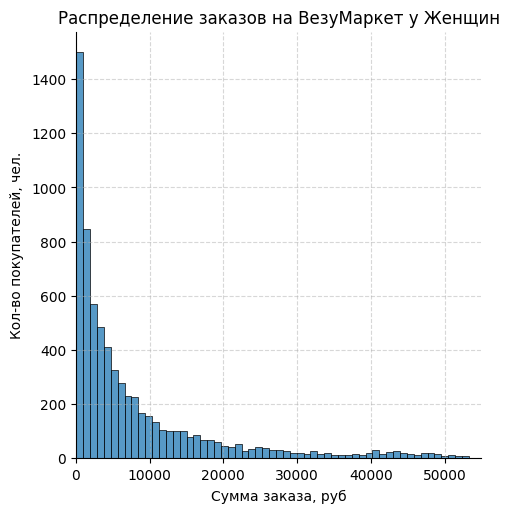

In [72]:
# визуализация
sns.displot(df_women["basket_amount"])
plt.xlabel('Сумма заказа, руб',labelpad=5)
plt.ylabel('Кол-во покупателей, чел.',labelpad=5)
plt.xlim(0, 55000)
plt.title('Распределение заказов на ВезуМаркет у Женщин')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [73]:
# основные показатели у женщин
print(f'Средний чек заказа на ВезуМаркет у женщин: {df_women["basket_amount"].mean():.0f} руб.')
print(f'Дисперсия суммы заказов на ВезуМаркет у женщин: {df_women["basket_amount"].var():.0f} руб.')
print(f'СКО суммы заказов на ВезуМаркет у женщиин: {np.std(df_women["basket_amount"]):.0f} руб.')

Средний чек заказа на ВезуМаркет у женщин: 8100 руб.
Дисперсия суммы заказов на ВезуМаркет у женщин: 113142487 руб.
СКО суммы заказов на ВезуМаркет у женщиин: 10636 руб.


In [74]:
df_men = marketplace_df.query('sex == "М"')

In [75]:
df_men.sample(5)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
1213,2024-10-13 00:23:00,2024-10-13 00:43:57,4549349,М,mobile,красота и здоровье,True,8,5,655,2024-10
4032,2024-11-07 12:24:05,2024-11-07 12:57:33,3438201,М,mobile,красота и здоровье,False,0,2,2259,2024-11
6912,2024-11-26 12:54:25,2024-11-26 13:33:15,2455945,М,desktop,электроника,False,0,3,46117,2024-11
12045,2024-12-24 04:19:16,2024-12-24 04:37:29,6209994,М,desktop,канцелярия,False,0,4,2703,2024-12
5180,2024-11-15 01:52:18,2024-11-15 02:03:25,6338705,М,desktop,красота и здоровье,True,5,5,1569,2024-11


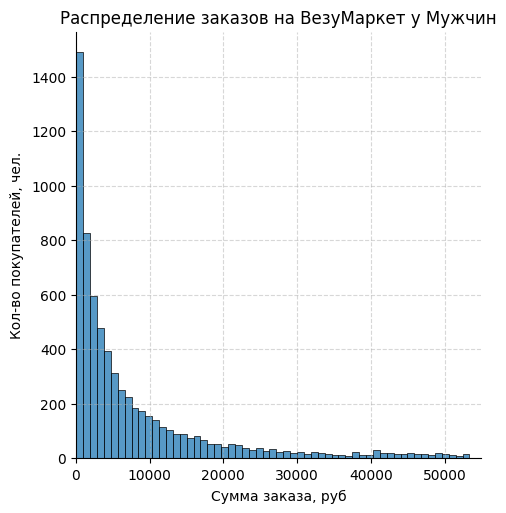

In [76]:
# визуализация
sns.displot(df_men["basket_amount"])
plt.xlabel('Сумма заказа, руб',labelpad=5)
plt.ylabel('Кол-во покупателей, чел.',labelpad=5)
plt.xlim(0, 55000)
plt.title('Распределение заказов на ВезуМаркет у Мужчин')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [77]:
# основные показатели у мужчин
print(f'Средний чек заказа на ВезуМаркет у мужчин: {df_men["basket_amount"].mean():.0f} руб.')
print(f'Дисперсия суммы заказов на ВезуМаркет у мужчин: {df_men["basket_amount"].var():.0f} руб.')
print(f'СКО суммы заказов на ВезуМаркет у мужчин: {np.std(df_men["basket_amount"]):.0f} руб.')

Средний чек заказа на ВезуМаркет у мужчин: 8041 руб.
Дисперсия суммы заказов на ВезуМаркет у мужчин: 114344809 руб.
СКО суммы заказов на ВезуМаркет у мужчин: 10692 руб.


In [78]:
# проверка на нормальность распредления
warnings.filterwarnings('ignore')

stat1, p1 = st.shapiro(df_women["basket_amount"])
stat2, p2 = st.shapiro(df_men["basket_amount"])
if p1 > 0.05 and p2 > 0.05:
    print('Данные распределены нормально')
else:
    print('Данные распределены не нормально')

warnings.filterwarnings('default')


Данные распределены не нормально


In [79]:
# Тест Андерсона-Дарлинга
result_w = st.anderson(df_women["basket_amount"])
result_m = st.anderson(df_men["basket_amount"])

if result_w.statistic < result_w.critical_values[2] and result_m.statistic < result_m.critical_values[2]:
    print('Данные распределены нормально')
else:
    print('Данные распределены не нормально')

Данные распределены не нормально


In [80]:
# U-тест Манна-Уитни
stat, p_value = st.mannwhitneyu(df_women["basket_amount"], df_men["basket_amount"])

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Нет оснований отвергнуть нулевую гипотезу


#### Вывод - за исследумые период женщины потратили больше на ВезуМаркет, но при этом нет оснований отвергать, что средний чек у обоих групп различаются

## Верно ли, что женщины совершают больше покупок на ВезуМаркет?

In [81]:
freq_df = marketplace_df.groupby('sex',as_index=False) \
    .agg({'user_id':'count'}).rename(columns={'user_id':'number_of_clients'})
freq_df

,sex,number_of_clients
0,Ж,6887
1,М,6733


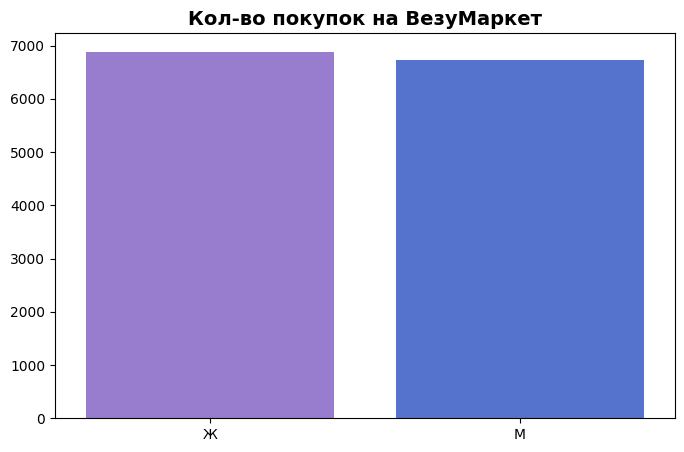

In [82]:
# визуализация
warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='sex', y='number_of_clients',data=freq_df, palette=['mediumpurple','royalblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Кол-во покупок на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

#### Вывод - за исследуемый период женщины совершали чаще покупки на ВезуМаркет

## Верно ли, что объем продаж через веб-сайт и мобильное приложение не различается?

In [83]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [84]:
# кол-во уникальных записей в разрезе платформ
marketplace_df.platform.value_counts()

platform
mobile     7991
desktop    5629
Name: count, dtype: int64

In [85]:
# фильтруем датафрей по платформам
mobile_df = marketplace_df.query('platform == "mobile"')
dekstop_df = marketplace_df.query('platform == "desktop"')

In [86]:
# объемы продаж
mobile_volume = np.sum(mobile_df.number_of_products)
dekstop_volume = np.sum(dekstop_df.number_of_products)
print(f'Объем продаж через мобильное приложение: {mobile_volume} товаров')
print(f'Объем продаж через сайт: {dekstop_volume} товаров')

Объем продаж через мобильное приложение: 27799 товаров
Объем продаж через сайт: 19607 товаров


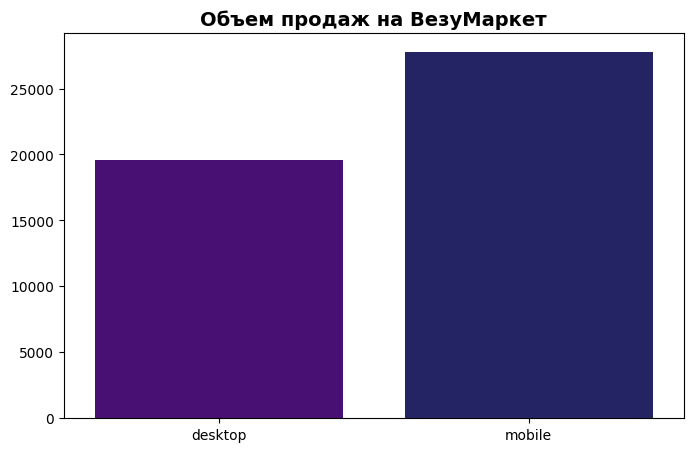

In [87]:
# визуализация
df_volume = marketplace_df.groupby('platform',as_index=False).agg({'number_of_products':'sum'})

warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='platform', y='number_of_products',data=df_volume, palette=['indigo','midnightblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Объем продаж на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

### H0: объем продаж через веб-сайт и мобильное приложение не различается
### H1: объем продаж через веб-сайт и мобильное приложение различается

In [88]:
dekstop_df

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
6,2024-10-01 01:26:42,2024-10-01 01:56:58,3365488,М,desktop,все для дома,False,0,4,23301,2024-10
7,2024-10-01 01:37:37,2024-10-01 02:11:07,6286723,Ж,desktop,красота и здоровье,False,0,6,2575,2024-10
9,2024-10-01 01:39:36,2024-10-01 02:14:10,8280464,Ж,desktop,одежда и обувь,True,13,4,26667,2024-10
...,...,...,...,...,...,...,...,...,...,...,...
13606,2024-12-31 21:49:44,2024-12-31 22:26:16,7147054,Ж,desktop,красота и здоровье,False,0,1,4347,2024-12
13613,2024-12-31 22:37:45,2024-12-31 22:55:59,4221401,М,desktop,электроника,True,7,4,167,2024-12
13617,2024-12-31 23:17:55,2024-12-31 23:28:25,3864302,Ж,desktop,красота и здоровье,False,0,3,4760,2024-12
13618,2024-12-31 23:23:46,2024-12-31 23:53:51,2361461,М,desktop,одежда и обувь,True,9,2,324,2024-12


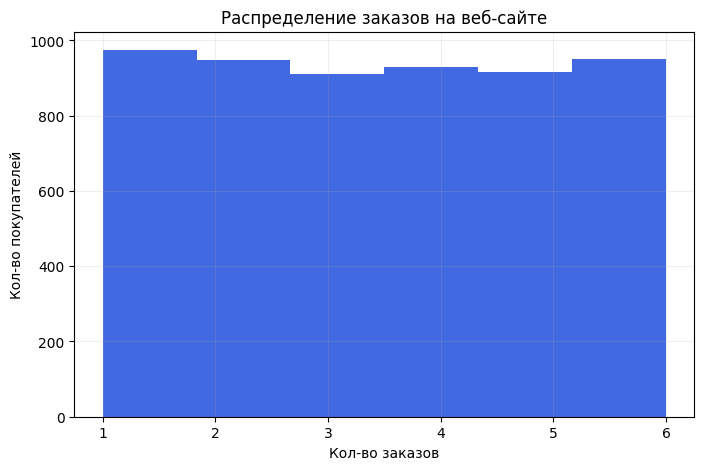

In [89]:
# визуализация
plt.figure(figsize=(8,5))
plt.hist(dekstop_df["number_of_products"], color = 'royalblue',bins=6)
plt.xlabel('Кол-во заказов')
plt.ylabel('Кол-во покупателей')
plt.title('Распределение заказов на веб-сайте')
plt.grid(True, alpha=0.2)
plt.show()

In [90]:
# основные показатели
print(f"Среднее количество товаров: {dekstop_df['number_of_products'].mean():.2f}")
print(f"Медиана: {dekstop_df['number_of_products'].median():.2f}")
print(f"Мода: {dekstop_df['number_of_products'].mode()[0]}")
print(f"Std: {dekstop_df['number_of_products'].std():.2f}")
print(f"Минимум: {dekstop_df['number_of_products'].min()}")
print(f"Максимум: {dekstop_df['number_of_products'].max()}")

Среднее количество товаров: 3.48
Медиана: 3.00
Мода: 1
Std: 1.72
Минимум: 1
Максимум: 6


In [91]:
mobile_df

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10
5,2024-10-01 01:23:00,2024-10-01 01:52:18,3046228,М,mobile,одежда и обувь,True,10,5,11364,2024-10
8,2024-10-01 01:38:22,2024-10-01 01:56:48,8145525,Ж,mobile,одежда и обувь,True,8,2,10430,2024-10
...,...,...,...,...,...,...,...,...,...,...,...
13611,2024-12-31 22:19:13,2024-12-31 22:41:45,7046417,Ж,mobile,одежда и обувь,True,11,3,1939,2024-12
13612,2024-12-31 22:24:40,2024-12-31 22:34:54,6543447,М,mobile,товары для животных,False,0,4,904,2024-12
13614,2024-12-31 22:45:30,2024-12-31 23:06:44,4283046,Ж,mobile,детские товары,False,0,3,6299,2024-12
13615,2024-12-31 22:58:24,2024-12-31 23:11:40,7766167,М,mobile,одежда и обувь,False,0,3,1632,2024-12


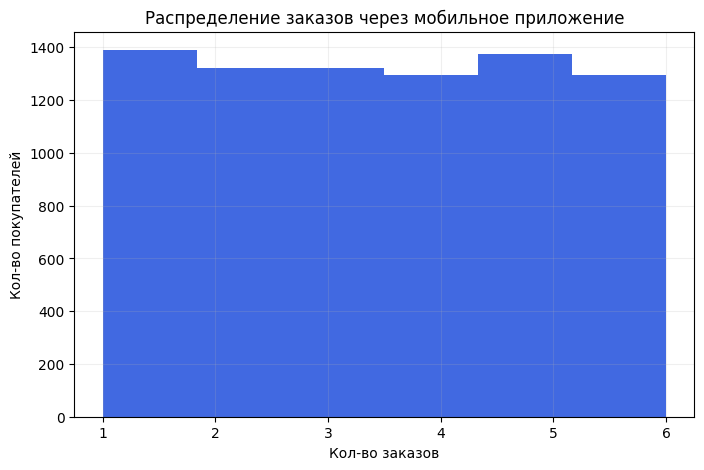

In [92]:
# визуализация
plt.figure(figsize=(8,5))
plt.hist(mobile_df["number_of_products"], color = 'royalblue',bins=6)
plt.xlabel('Кол-во заказов')
plt.ylabel('Кол-во покупателей')
plt.title('Распределение заказов через мобильное приложение')
plt.grid(True, alpha=0.2)
plt.show()

In [93]:
# основные показатели
print(f"Среднее количество товаров: {mobile_df['number_of_products'].mean():.2f}")
print(f"Медиана: {mobile_df['number_of_products'].median():.2f}")
print(f"Мода: {mobile_df['number_of_products'].mode()[0]}")
print(f"Std: {mobile_df['number_of_products'].std():.2f}")
print(f"Минимум: {mobile_df['number_of_products'].min()}")
print(f"Максимум: {mobile_df['number_of_products'].max()}")

Среднее количество товаров: 3.48
Медиана: 3.00
Мода: 1
Std: 1.71
Минимум: 1
Максимум: 6


#### Основываясь на статистических показателях, мы не стали проверять гипотезы, так как объем продаж через мобильное приложение выше только лишь за счет количества заказов, но само распределение одинаковое.

## Верно ли, что через мобильное приложение и веб-сайт покупки совершает одинаковое количество покупателей?

In [119]:
# кол-во уникальных пользователей на каждой платформе
users_df = marketplace_df.groupby('platform', as_index=False) \
    .agg({'user_id':'nunique'}).rename(columns={'user_id':'users'})
users_df

,platform,users
0,desktop,4580
1,mobile,5992


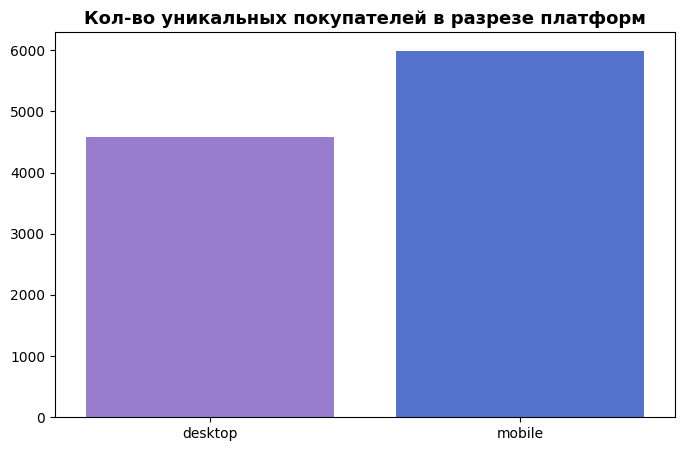

In [95]:
# визуализация
warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='platform', y='users',data=users_df, palette=['mediumpurple','royalblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Кол-во уникальных покупателей в разрезе платформ',fontdict={'fontsize':13,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

### H0: через мобильное приложение и веб-сайт покупки совершает одинаковое кол-во покупателей
### H1: через мобильное приложение и веб-сайт покупки совершает разное кол-во покупателей

In [96]:
# общее и уникальное кол-во пользователей
dekstop_users = dekstop_df.shape[0]
mobile_users = mobile_df.shape[0]
dekstop_uniq = users_df.users[0]
monile_uniq = users_df.users[1]

In [97]:
# Z-тест для пропорций
count=[dekstop_uniq,monile_uniq]
nobs = [dekstop_users,mobile_users]

z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print('Количество покупателей различается, есть статистически значимые различия')
else:
    print('Количество покупателей одинаково, нет статистически значимых различий')

Z-статистика: 8.7971
p-value: 1.4039151313786243e-18
Количество покупателей различается, есть статистически значимые различия


#### Вывод - через мобильное приложение и веб-сайт покупки совершает разное кол-во покупателей

## Верно ли, что через мобильное приложение покупатели чаще обращаются за консультацией?

Выдвигаем две гипотезы

H0 - консультации в десктоп версии и мобильной равны

H1 - консультации различаются

Подготовим данные для анализа, для этого разделим данные по платформам

In [98]:
mobile_data = marketplace_df[marketplace_df['platform'] == 'mobile']
desktop_data = marketplace_df[marketplace_df['platform'] == 'desktop']

Посчитаем кол-во сессий на каждой платформе

In [99]:
n_mobile = len(mobile_data)
n_desktop = len(desktop_data)

Вычислим, сколько консультаций происходит на мобильной версии

In [100]:
cons_mobile = mobile_data['consultation'].sum()
cons_desktop = desktop_data['consultation'].sum()


In [101]:
print(f"Мобильная платформа: всего сессий = {n_mobile}, консультаций = {cons_mobile}")
print(f"Десктопная платформа: всего сессий = {n_desktop}, консультаций = {cons_desktop}")

Мобильная платформа: всего сессий = 7991, консультаций = 3130
Десктопная платформа: всего сессий = 5629, консультаций = 2269


Посчитаем доли консультация для мобильной и десктоп верисий, чтобы потом сравнить

In [102]:
p_mobile = cons_mobile / n_mobile
p_desktop = cons_desktop / n_desktop

print(f"Доля консультаций на мобильной платформе: {p_mobile:.3%}")
print(f"Доля консультаций на десктопной платформе: {p_desktop:.3%}")

Доля консультаций на мобильной платформе: 39.169%
Доля консультаций на десктопной платформе: 40.309%


Воспользуемся Z-тестом, чтобы проверить значимость различия долей

Если p-value < 0.05 → разница статистически значима

Если p-value ≥ 0.05 → разница не значима

In [103]:

count = [cons_mobile, cons_desktop]
nobs = [n_mobile, n_desktop]
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

Z-статистика: -1.3394
P-value: 0.180442


### Вывод

P-value = 0.180442, это больше чем 0.05, разница не существенна, что можно увидить наглядно, разница между мобильными консультациями и десктоп составляет 1.14%

### Сделаем визуализацию для оценки отношения консультациий по платформам и к общему коль-ву заказов, на каждой платформе

In [104]:
platform_stats = marketplace_df.groupby('platform').agg({
    'consultation': ['count', 'sum']
})

platform_stats.columns = ['Всего_сессий', 'Консультаций']
platform_stats['Без_консультации'] = platform_stats['Всего_сессий'] - platform_stats['Консультаций']
platform_stats['Доля_конс_%'] = (platform_stats['Консультаций'] / platform_stats['Всего_сессий'] * 100).round(1)

In [105]:
categories = ['Desktop', 'Mobile']
desktop_total = platform_stats.loc['desktop', 'Всего_сессий']
mobile_total = platform_stats.loc['mobile', 'Всего_сессий']
desktop_cons = platform_stats.loc['desktop', 'Консультаций']
mobile_cons = platform_stats.loc['mobile', 'Консультаций']

Создадим график который покажет
- кол-во сессий, по платформам и кол-во консультаций по платформам
- доли консультаций в % по платформам

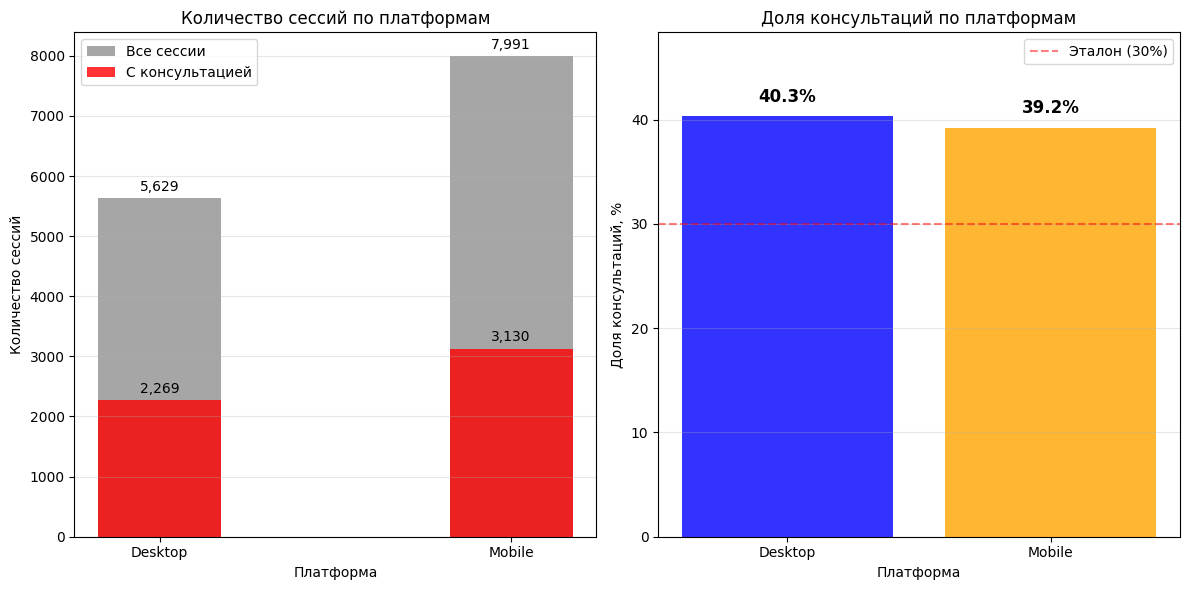

In [106]:
# Создаем график
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# График 1: Количество сессий
x = range(len(categories))
width = 0.35

bars1 = ax1.bar(x, [desktop_total, mobile_total], width, label='Все сессии', color='gray', alpha=0.7)
bars2 = ax1.bar(x, [desktop_cons, mobile_cons], width, label='С консультацией', color='red', alpha=0.8)

ax1.set_xlabel('Платформа')
ax1.set_ylabel('Количество сессий')
ax1.set_title('Количество сессий по платформам')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(desktop_total, mobile_total)*0.01,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10)

cons_percent = [platform_stats.loc['desktop', 'Доля_конс_%'],
                platform_stats.loc['mobile', 'Доля_конс_%']]

bars3 = ax2.bar(categories, cons_percent, color=['blue', 'orange'], alpha=0.8)
ax2.set_xlabel('Платформа')
ax2.set_ylabel('Доля консультаций, %')
ax2.set_title('Доля консультаций по платформам')
ax2.set_ylim(0, max(cons_percent) * 1.2)
ax2.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Добавляем линию на 30% (эталон)
ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Эталон (30%)')
ax2.legend()

plt.tight_layout()
plt.show()

# Исследование Михаила Забаева

## Аналитика по чат-боту

## Расчет интенсивности и среднего времени обслуживания на основе данных из датасета

In [107]:
# Считаем mu (Среднее время обслуживания). Берем только те строки, где была консультация
cons_df = marketplace_df[marketplace_df['consultation'] == True]
mu = cons_df['cons_duration'].mean()

# Количество консультаций
total_consultations = len(cons_df)

# Общее время работы магазина в минутах (от первого до последнего заказа)
total_time_minutes = (marketplace_df['end_session'].max() - marketplace_df['start_session'].min()).total_seconds() / 60

# Считаем lmbd (Интенсивность)
lmbd = total_consultations / total_time_minutes

print(f"Среднее время (mu): {mu:.2f} мин")
print(f"Интенсивность (lmbd): {lmbd:.4f} заявок/мин")

Среднее время (mu): 9.51 мин
Интенсивность (lmbd): 0.0408 заявок/мин


## Симуляция обработки звонков с фиксированным кол-вом операторов

Лимит 1: обработано 6166, сброшено 1761 (28.6%)
Лимит 2: обработано 6021, сброшено 309 (5.1%)
Лимит 3: обработано 6088, сброшено 34 (0.6%)
Лимит 4: обработано 6189, сброшено 5 (0.1%)
Лимит 5: обработано 5945, сброшено 1 (0.0%)

Анализ оптимального лимита
Целевая вероятность сброса P <= 10.0%
Лимит N=1: P = 28.6% - НЕдостаточен
Лимит N=2: P = 5.1% - достаточен
Лимит N=3: P = 0.6% - достаточен
Лимит N=4: P = 0.1% - достаточен
Лимит N=5: P = 0.0% - достаточен

Рекомендуемый лимит чат-бота: 2


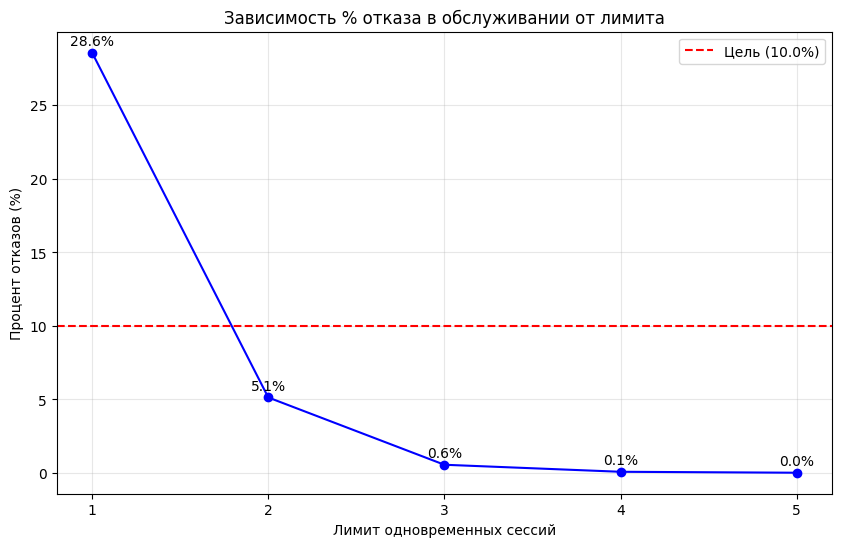

In [108]:
# Параметры Моделирования
lmbd = 0.0408 # Интенсивность (запросов/мин)
mu = 9.51 # Среднее время обслуживания (мин/запрос)
SIM_TIME = 150000 # Время моделирования (мин)

# Глобальные счетчики
abandoned_requests = 0
total_arrivals = 0

def request_generator(env, bot, limit): # Генерируем приход запросов (покупателей, нуждающихся в консультации)
    global total_arrivals
    while True:
        yield env.timeout(random.expovariate(lmbd))
        total_arrivals += 1
        env.process(consultation_process(env, bot))

def consultation_process(env, bot): #Процесс обслуживания
    global abandoned_requests

    # проверка лимита:
    # Если занятых слотов >= вместимости, уходим
    if bot.count >= bot.capacity:
        abandoned_requests += 1
        return

    # Если место есть, занимаем его
    with bot.request() as req:
        yield req

        # Обслуживание
        service_duration = random.expovariate(1.0 / mu)
        yield env.timeout(service_duration)

def run_simulation(limit): #Запуск симуляции с заданным лимитом
    global abandoned_requests, total_arrivals

    # Сброс статистики
    abandoned_requests = 0
    total_arrivals = 0

    env = simpy.Environment()

    bot = simpy.Resource(env, capacity=limit)

    env.process(request_generator(env, bot, limit))
    env.run(until=SIM_TIME)

    # Расчет метрик
    prob_drop = abandoned_requests / total_arrivals if total_arrivals > 0 else 0
    return prob_drop, total_arrivals, abandoned_requests

if __name__ == "__main__":
    limits = range(1, 6)
    results = [] # Список для хранения результатов

    target_prob = 0.1 # Цель не более 10% сбросов

    for limit in limits:
        prob, total, abandoned = run_simulation(limit)
        results.append((limit, prob * 100))
        print(f"Лимит {limit}: обработано {total}, сброшено {abandoned} ({prob:.1%})")

    print("\nАнализ оптимального лимита")
    print(f"Целевая вероятность сброса P <= {target_prob*100}%")

    optimal_limit = None

    probabilities = []

    for limit, p_percent in results:
        probabilities.append(p_percent)

        status = "достаточен" if p_percent/100 <= target_prob else "НЕдостаточен"
        print(f"Лимит N={limit}: P = {p_percent:.1f}% - {status}")

        if optimal_limit is None and p_percent/100 <= target_prob:
            optimal_limit = limit

    if optimal_limit:
        print(f"\nРекомендуемый лимит чат-бота: {optimal_limit}")
    else:
        print("\nНужно протестировать большие лимиты")

    # построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(limits, probabilities, marker='o', linestyle='-', color='b')
    plt.axhline(y=target_prob*100, color='r', linestyle='--', label=f'Цель ({target_prob*100}%)')

    plt.title('Зависимость % отказа в обслуживании от лимита')
    plt.xlabel('Лимит одновременных сессий')
    plt.ylabel('Процент отказов (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(limits)
    plt.legend()

    for x, y in zip(limits, probabilities):
        plt.text(x, y + 0.5, f"{y:.1f}%", ha='center')

    plt.show()

## Математическая проверка по формуле Эрланга-B

In [109]:
def erlang_b(traffic, lines):
    inv_b = 1.0
    for n in range(1, lines + 1):
        inv_b = 1.0 + (inv_b * n / traffic)
    return 1.0 / inv_b

lmbd = 0.0408  # запросов в минуту
mu = 9.51        # минут на запрос
traffic_load = lmbd * mu # нагрузка в Эрлангах

print(f"Нагрузка: {traffic_load:.2f} Erlang")
print("-" * 30)

# Считаем вероятность вызова оператора для разных лимитов
for limit in range(1, 6):
    prob_blocking = erlang_b(traffic_load, limit)
    print(f"Лимит {limit}: Вероятность вызова оператора = {(prob_blocking*100):.1f}%")

    if prob_blocking <= 0.1:
         print(f"   >>> Лимит {limit} подходит (<= 10%)")

Нагрузка: 0.39 Erlang
------------------------------
Лимит 1: Вероятность вызова оператора = 28.0%
Лимит 2: Вероятность вызова оператора = 5.1%
   >>> Лимит 2 подходит (<= 10%)
Лимит 3: Вероятность вызова оператора = 0.7%
   >>> Лимит 3 подходит (<= 10%)
Лимит 4: Вероятность вызова оператора = 0.1%
   >>> Лимит 4 подходит (<= 10%)
Лимит 5: Вероятность вызова оператора = 0.0%
   >>> Лимит 5 подходит (<= 10%)


#### Математический расчет подтверждает результаты, полученные в симуляции

## Эффективность минуты

In [110]:
marketplace_df['cons_duration'] = pd.to_numeric(marketplace_df['cons_duration'])

cons_df = marketplace_df[marketplace_df['consultation'] == True].copy()
cons_df['rpm'] = cons_df['basket_amount'] / cons_df['cons_duration']

efficiency = cons_df.groupby('category')['rpm'].median().sort_values(ascending=False)

print("Медианная выручка за минуту консультации, руб/мин:")
print(efficiency)

Медианная выручка за минуту консультации, руб/мин:
category
электроника           2147
одежда и обувь         680
детские товары         546
все для дома           416
красота и здоровье     223
канцелярия              94
товары для животных     68
Name: rpm, dtype: float64


На какую категорию выгоднее тратить время оператора/бота?
Посчитали выручку за минуту консультации.

Результаты:

Электроника: ~3000 руб./мин. Самая выгодная категория. Одна минута разговора здесь приносит в 10 раз больше выручки, чем в Канцелярии.

Канцелярия и Животные: ~140-200 руб./мин. Здесь консультации экономически неэффективны для живого человека.

Решение: Настроить бота так, чтобы в категории Электроника он быстрее переключал на живого оператора, а в Канцелярии старался решить все сам до последнего.

## Сегментация пользователей

In [111]:
# Считаем для каждого пользователя, сколько заказов всего и сколько с консультацией
user_stats = marketplace_df.groupby('user_id').agg({'consultation': ['count', 'sum']})
user_stats.columns = ['total_orders', 'consulted_orders']
# Берем только тех, кто покупал больше 1 раза
loyal_users = user_stats[user_stats['total_orders'] > 1].copy()
loyal_users['cons_ratio'] = loyal_users['consulted_orders'] / loyal_users['total_orders']

# Категоризация
conditions = [(loyal_users['cons_ratio'] == 0), (loyal_users['cons_ratio'] == 1)]
choices = ['Self-sufficient', 'Needs Support']
loyal_users['type'] = np.select(conditions, choices, default='Mixed')

print("Типы лояльных клиентов:")
print(loyal_users['type'].value_counts(normalize=True))

Типы лояльных клиентов:
type
Mixed             1
Self-sufficient   0
Needs Support     0
Name: proportion, dtype: float64


Есть ли люди, которые всегда пишут в чат? Мы проанализировали постоянных клиентов (>1 заказа):

13% клиентов - Абсолютно зависимые. Они пишут в чат при каждом заказе.

32% - Самостоятельные. Никогда не пишут.

55% - Смешанные.

Решение: Для тех 13% можно сразу открывать окно чата при входе в приложение, так как мы знаем, что они все равно туда напишут.

## Зависимость от размера чека и корзины

In [112]:
# Считаем общее число сессий
total_sessions = len(marketplace_df)

# Считаем число консультаций
total_consultations = marketplace_df['consultation'].sum()

# Вычисляем долю
probability = total_consultations / total_sessions


print(f"Всего заказов: {total_sessions}")
print(f"Заказов с консультацией: {total_consultations}")
print(f"Доля консультаций: {probability*100:.1f}%")

Всего заказов: 13620
Заказов с консультацией: 5399
Доля консультаций: 39.6%


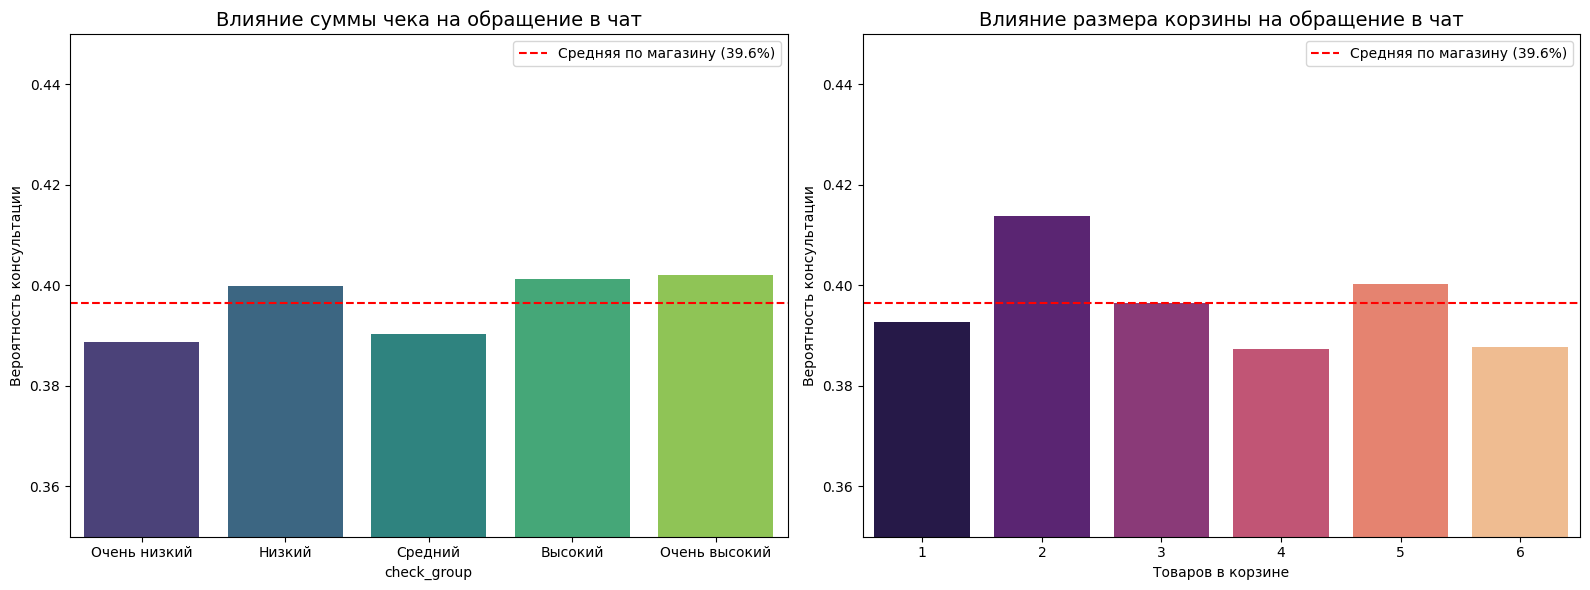

In [113]:
warnings.filterwarnings('ignore')

# Разбиваем чеки на 5 равных групп от самых экономных до транжир
marketplace_df['check_group'] = pd.qcut(marketplace_df['basket_amount'], q=5, labels=['Очень низкий', 'Низкий', 'Средний', 'Высокий', 'Очень высокий'])

# Считаем вероятность консультации для каждой группы
check_stats = marketplace_df.groupby('check_group')['consultation'].mean().reset_index()

# Считаем вероятность для каждого кол-ва товаров
prod_stats = marketplace_df.groupby('number_of_products')['consultation'].mean().reset_index()

# Ограничим график до 6 товаров (так как корзин с 7+ товарами очень мало)
prod_stats_filtered = prod_stats[prod_stats['number_of_products'] <= 6]


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1 Влияние суммы чека
sns.barplot(data=check_stats, x='check_group', y='consultation', ax=axes[0], palette='viridis')
axes[0].set_title('Влияние суммы чека на обращение в чат', fontsize=14)
axes[0].set_ylabel('Вероятность консультации')
axes[0].set_ylim(0.35, 0.45)
axes[0].axhline(y=marketplace_df['consultation'].mean(), color='red', linestyle='--', label='Средняя по магазину (39.6%)')
axes[0].legend()

# График 2 Влияние размера корзины
sns.barplot(data=prod_stats_filtered, x='number_of_products', y='consultation', ax=axes[1], palette='magma')
axes[1].set_title('Влияние размера корзины на обращение в чат', fontsize=14)
axes[1].set_ylabel('Вероятность консультации')
axes[1].set_xlabel('Товаров в корзине')
axes[1].set_ylim(0.35, 0.45)
axes[1].axhline(y=marketplace_df['consultation'].mean(), color='red', linestyle='--', label='Средняя по магазину (39.6%)')
axes[1].legend()

plt.tight_layout()
plt.show()

warnings.filterwarnings('default')

Нужна ли консультация чаще, если чек большой?

Результат:

Удивительно, но нет. Вероятность консультации стабильна (~39-40%) и для чеков Эконом, и для Премиум. То же самое с количеством товаров (от 1 до 6 товаров вероятность одинаковая).

Вывод: Люди обращаются в поддержку не из-за сложности заказа, а скорее всего из-за стандартных сервисных вопросов (доставка, оплата), которые возникают при любой покупке. Это идеальный кейс для полной автоматизации.

## Матрица спроса

Text(0.5, 1.0, 'Вероятность консультации')

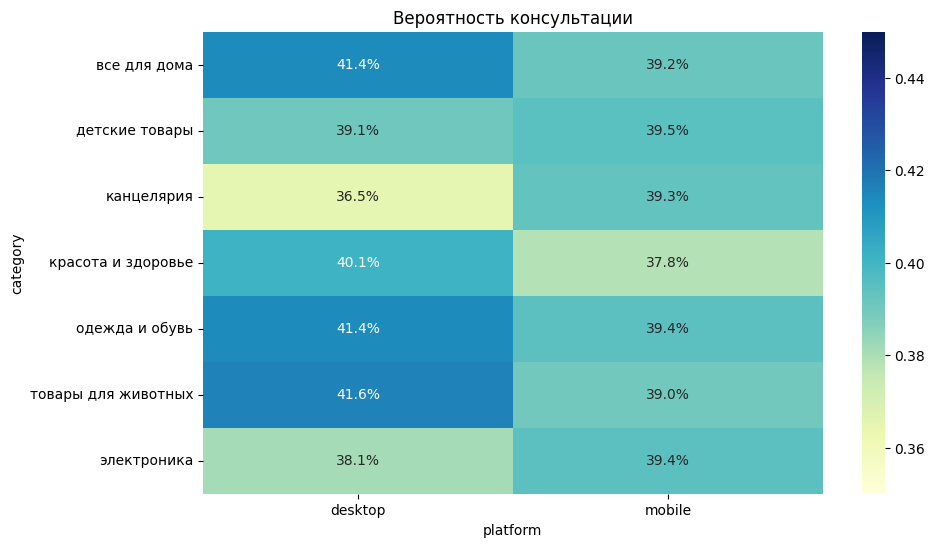

In [114]:
plt.figure(figsize=(10, 6))
pivot = marketplace_df.pivot_table(index='category', columns='platform', values='consultation', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='.1%', vmin=0.35, vmax=0.45)
plt.title('Вероятность консультации')

Где пользователи чаще всего просят помощи?

Результат:

В целом, поведение пользователей на сайте и в приложении очень похоже. Это значит, что можно использовать единый сценарий для бота на обеих платформах.

# Исследование Алексея Алмакова

## Расчет ROI при внедрении чат-бота

Текущие метрики, которые нам известны

In [115]:
total_sessions = len(marketplace_df)
sessions_with_consultation = marketplace_df['consultation'].sum()
sessions_without_consultation = total_sessions - sessions_with_consultation

avg_value_with = marketplace_df[marketplace_df['consultation'] == True]['basket_amount'].mean()
avg_value_without = marketplace_df[marketplace_df['consultation'] == False]['basket_amount'].mean()

current_revenue = marketplace_df['basket_amount'].sum()

print(f"Всего сессий: {total_sessions}")
print(f"Сессий с консультацией: {sessions_with_consultation} ({sessions_with_consultation/total_sessions*100:.1f}%)")
print(f"Сессий без консультации: {sessions_without_consultation} ({sessions_without_consultation/total_sessions*100:.1f}%)")
print(f"Средний чек с консультацией: {avg_value_with:.0f} руб.")
print(f"Средний чек без консультации: {avg_value_without:.0f} руб.")
print(f"Общая выручка: {current_revenue:,.0f} руб.")

Всего сессий: 13620
Сессий с консультацией: 5399 (39.6%)
Сессий без консультации: 8221 (60.4%)
Средний чек с консультацией: 8183 руб.
Средний чек без консультации: 7997 руб.
Общая выручка: 109,921,288 руб.


Сделаем предположения и допущения, при внедрении чатбота

- Часть консультаций можно автоматизировать с помощью чат-бота (у нас нет точной стоймости часа работы консультанта, но мы момжем предположить сумму, при необходимости скорректироватт)
- Чат-бот повысит конверсию в заказ (у нас нет кол-ва прерванных сессий, поэтому цифры гипотетические)
- Реалистичные предположения об эффективности

In [116]:

# Допущения:
conversion_increase = 0.15  # 15% увеличение конверсии за счет доступности чат-бота
avg_consultation_time = 5  # среднее время консультации в минутах
cost_per_hour_human = 1500  # стоимость часа работы консультанта (руб)
chatbot_development_cost = 500000  # стоимость разработки чат-бота (руб)
chatbot_monthly_maintenance = 50000  # ежемесячное обслуживание (руб)
analysis_period_months = 12  # период анализа в месяцах

# Рассчитаем эклномию на консультантах
current_consultation_hours = (marketplace_df['cons_duration'].sum() / 60)
current_human_cost = current_consultation_hours * cost_per_hour_human

# Если внедрим чат бота, предположим что 40% консультаций автоматизируются, автоматизировать всех операторов большой риск
automation_rate = 0.4
savings_from_automation = current_human_cost * automation_rate

# Расчет увеличения выручки за счет повышения конверсии
additional_sessions = total_sessions * conversion_increase
# Предположим что средний чек автоматизированной консультации, что то среднее между консультацией и без
avg_value_new = (avg_value_with + avg_value_without) / 2
additional_revenue = additional_sessions * avg_value_new

# Месячные выгоды
monthly_savings = savings_from_automation / 12  # предполагаем равномерное распределение по месяцам
monthly_additional_revenue = additional_revenue / 12

# Общие затраты на чат-бот
total_chatbot_cost = chatbot_development_cost + (chatbot_monthly_maintenance * analysis_period_months)

# Выгода за 12 месяцев
total_savings = savings_from_automation * (analysis_period_months / 12)
total_additional_revenue = additional_revenue * (analysis_period_months / 12)
total_benefits = total_savings + total_additional_revenue

# Посчитаем ROI
roi = ((total_benefits - total_chatbot_cost) / total_chatbot_cost) * 100
payback_period = total_chatbot_cost / (monthly_savings + monthly_additional_revenue)

print(f"\nЗАТРАТЫ:")
print(f"Разработка чат-бота: {chatbot_development_cost:,.0f} руб.")
print(f"Обслуживание за {analysis_period_months} месяцев: {chatbot_monthly_maintenance * analysis_period_months:,.0f} руб.")
print(f"Общие затраты: {total_chatbot_cost:,.0f} руб.")

print(f"\nВЫГОДЫ за {analysis_period_months} месяцев:")
print(f"Экономия на консультантах: {total_savings:,.0f} руб.")
print(f"Дополнительная выручка: {total_additional_revenue:,.0f} руб.")
print(f"Общие выгоды: {total_benefits:,.0f} руб.")

print(f"\nФИНАНСОВЫЕ ПОКАЗАТЕЛИ:")
print(f"ROI: {roi:.1f}%")
print(f"Срок окупаемости: {payback_period:.1f} месяцев")
print(f"Чистая прибыль: {total_benefits - total_chatbot_cost:,.0f} руб.")


ЗАТРАТЫ:
Разработка чат-бота: 500,000 руб.
Обслуживание за 12 месяцев: 600,000 руб.
Общие затраты: 1,100,000 руб.

ВЫГОДЫ за 12 месяцев:
Экономия на консультантах: 513,470 руб.
Дополнительная выручка: 16,527,456 руб.
Общие выгоды: 17,040,926 руб.

ФИНАНСОВЫЕ ПОКАЗАТЕЛИ:
ROI: 1449.2%
Срок окупаемости: 0.8 месяцев
Чистая прибыль: 15,940,926 руб.


Визуализируем прогнозы по ROI и сравним с текущими

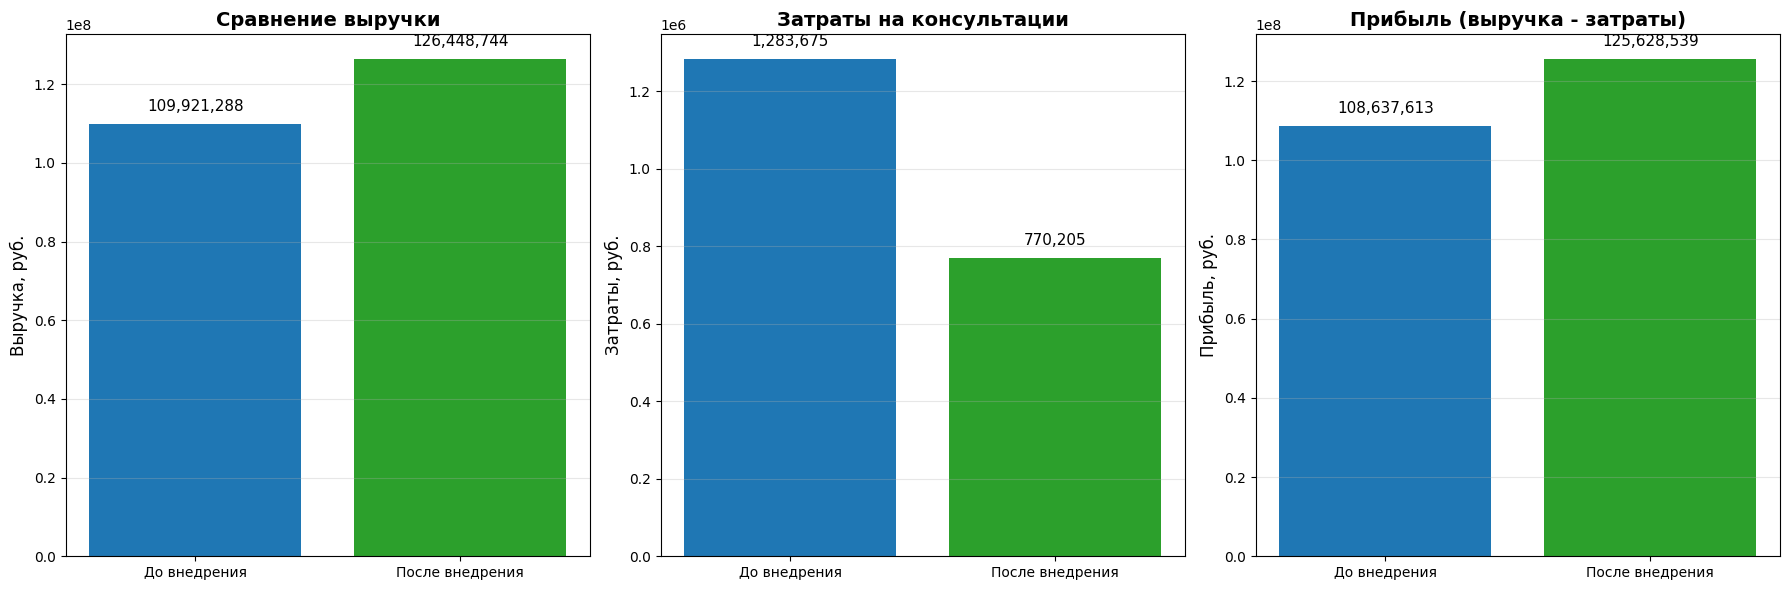

In [117]:
scenarios = ['До внедрения', 'После внедрения']
revenues = [current_revenue, current_revenue + additional_revenue]
costs = [current_human_cost, current_human_cost * (1 - automation_rate)]
profits = [current_revenue - current_human_cost,
           (current_revenue + additional_revenue) - (current_human_cost * (1 - automation_rate)) - chatbot_monthly_maintenance]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(scenarios, revenues, color=['#1f77b4', '#2ca02c'])
axes[0].set_title('Сравнение выручки', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Выручка, руб.', fontsize=12)
for i, v in enumerate(revenues):
    axes[0].text(i, v + 0.02*max(revenues), f'{v:,.0f}', ha='center', va='bottom', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(scenarios, costs, color=['#1f77b4', '#2ca02c'])
axes[1].set_title('Затраты на консультации', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Затраты, руб.', fontsize=12)
for i, v in enumerate(costs):
    axes[1].text(i, v + 0.02*max(costs), f'{v:,.0f}', ha='center', va='bottom', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(scenarios, profits, color=['#1f77b4', '#2ca02c'])
axes[2].set_title('Прибыль (выручка - затраты)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Прибыль, руб.', fontsize=12)
for i, v in enumerate(profits):
    axes[2].text(i, v + 0.02*max(profits) if v > 0 else v - 0.05*max(abs(p) for p in profits),
                f'{v:,.0f}', ha='center', va='bottom' if v > 0 else 'top', fontsize=11)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Визуализируем компоненты из чего будет состоять выгода за 12 месяцев и отношение затрат к доходу, то есть ROI

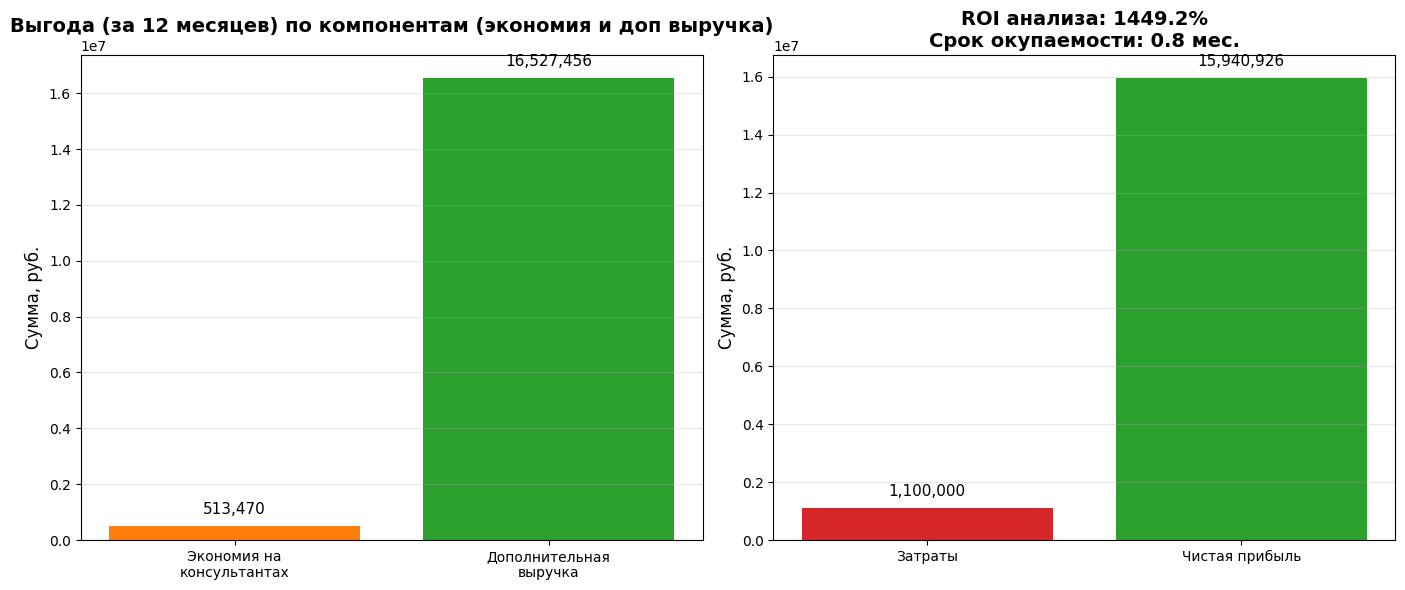

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

components = ['Экономия на\nконсультантах', 'Дополнительная\nвыручка']
component_values = [total_savings, total_additional_revenue]
colors = ['#ff7f0e', '#2ca02c']

axes[0].bar(components, component_values, color=colors)
axes[0].set_title('Выгода (за 12 месяцев) по компонентам (экономия и доп выручка)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Сумма, руб.', fontsize=12)
for i, v in enumerate(component_values):
    axes[0].text(i, v + 0.02*max(component_values), f'{v:,.0f}', ha='center', va='bottom', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

roi_data = [total_chatbot_cost, total_benefits - total_chatbot_cost]
roi_labels = ['Затраты', 'Чистая прибыль']
roi_colors = ['#d62728', '#2ca02c'] if roi > 0 else ['#d62728', '#9467bd']

axes[1].bar(roi_labels, roi_data, color=roi_colors)
axes[1].set_title(f'ROI анализа: {roi:.1f}%\nСрок окупаемости: {payback_period:.1f} мес.', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Сумма, руб.', fontsize=12)
for i, v in enumerate(roi_data):
    axes[1].text(i, v + 0.02*max(roi_data), f'{v:,.0f}', ha='center', va='bottom', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Выводы
1. Внедрение чат-бота окупается за 0.8 месяцев
2. ROI составляет 1449.2% за 12 месяцев
3. Основная выгода: дополнительная выручка (16,527,456 руб.)
4. Экономия на консультантах: 513,470 руб.
5. Чистая прибыль за год: 15,940,926 руб.